In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit
import seaborn as sns
import awkward as ak

from progressbar import progressbar
import re

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
paths = {
    '550' : {
        'exp' : 'root://sl10cmd//scan2011/scan2011_tr_ph_fc_e550_v8.root',
        'mc'  : '/store17/petrov/data/kskl20/tr_ph/11/tr_ph_kskl_550_9158.root',
        'mlt' : 'root://sl10cmd//sim/tr_ph_run045046_v5.root',
    },
    '550_19' : {
        'exp' : 'root://sl10cmd//scan2019/scan2019_tr_ph_fc_e550_v8.root',
        'mc'  : '/store17/petrov/data/kskl20/tr_ph/19/tr_ph_kskl_550_70260.root',
        'mlt' : '/store17/petrov/data/kskl20/tr_ph/multi/tr_ph_kskl_550_70260.root',
    },
    '600' : {
        'exp' : 'root://sl10cmd//scan2011/scan2011_tr_ph_fc_e600_v8.root',
        'mc'  : '/store17/petrov/data/kskl20/tr_ph/11/tr_ph_kskl_600_9407.root',
        'mlt' : 'root://sl10cmd//sim/tr_ph_run045875_v5.root',
    },
    '625_19' : {
        'exp' : 'root://sl10cmd//scan2019/scan2019_tr_ph_fc_e625_v8.root',
        'mc'  : '/store17/petrov/data/kskl20/tr_ph/19/tr_ph_kskl_625_72787.root',
        'mlt' : '/store17/petrov/data/kskl20/tr_ph/multi/19/tr_ph_run045573.root',
        'kkp' : '/store17/petrov/data/kskl20/tr_ph/kkp0/tr_ph_run045773.root'
    },    
    '800' : {
        'exp' : 'root://sl10cmd//scan2011/scan2011_tr_ph_fc_e800_v8.root',
        'mc'  : '/store17/petrov/data/spool_storage/tr_ph_kskl_800_10364.root',
        'mlt' : '/store17/petrov/data/spool_storage/multi_800_v8.root',
        'kkp' : 'root://sl10cmd//sim/tr_ph_run014211_v5.root',
        'kkpp': 'root://sl10cmd//sim/tr_ph_run032510_v5.root',
    },
    '800_19' : {
        'exp' : 'root://sl10cmd//scan2019/scan2019_tr_ph_fc_e800_v8.root',
        'mc'  : '/store17/petrov/data/kskl20/tr_ph/19/tr_ph_kskl_800_76450.root',
        'mlt' : '/store17/petrov/data/spool_storage/multi_800_v8.root',
        'kkp' : 'root://sl10cmd//sim/tr_ph_run014211_v5.root',
        'kkpp': 'root://sl10cmd//sim/tr_ph_run032510_v5.root',
    },
    '800_12' : {
        'exp' : 'root://sl10cmd//scan2012/scan2012_tr_ph_fc_e800_v8.root',
        'mc'  : '/store17/petrov/data/kskl20/tr_ph/12/tr_ph_kskl_800_15287.root',
        'mlt' : '/store17/petrov/data/spool_storage/multi_800_v8.root',
        'kkp' : 'root://sl10cmd//sim/tr_ph_run014211_v5.root',
        'kkpp': 'root://sl10cmd//sim/tr_ph_run032510_v5.root',
    },
    '925' : {
        'exp' : 'root://sl10cmd//scan2011/scan2011_tr_ph_fc_e925_v8.root',
        'mc'  : '/store17/petrov/data/kskl20/tr_ph/11/tr_ph_kskl_925_10796.root',
        'mlt' : '/store17/petrov/data/spool_storage/multi.root',
    },
    '925_19' : {
        'exp' : 'root://sl10cmd//scan2019/scan2019_tr_ph_fc_e925_v8.root',
        'mc' : '/store17/petrov/data/kskl20/tr_ph/19/tr_ph_kskl_925_78931.root',
        'mlt' : '/store17/petrov/data/kskl20/tr_ph/multi/19/tr_ph_run053303.root',
    }
}

In [4]:
# for i in progressbar(trs[1:]):
#     tr_ex = uproot.open(i.strip())['tr_ph']
#     h = preprocess.Handler(tr_ex)
#     df_ex = h.get_good_kaons()
#     e = float(re.findall(r'_(\d+.?\d*)_', i.strip())[0])
#     df_ex.to_csv(f'../csv/mc/v7/11/{e:.2f}.csv') #df_ex.iloc[0].ebeam

In [5]:
path0 = paths['800_19']
# path_ex, path_mc, path_mlt = path0['exp']

In [6]:
tr = {i : uproot.open(path0[i])['tr_ph'] for i in path0}

In [7]:
import vector

In [8]:
def ctr(df, c=0, ptot_cut=40):
    df = df.query(f'(abs(trho_n)>{c})&(abs(trho_p)>{c})&(tptot_p>{ptot_cut})&(tptot_n>{ptot_cut})&(ksdpsi<3)&(abs(tz_p)<12)&(abs(tz_n)<12)').copy()
    vec = vector.array({
        'pt' : df['ksptot']*np.sin(df['ksth']),
        'theta' : df['ksth'],
        'phi' : df['ksphi'],
        'mass' : df['ksminv'],
    })
    vec0 = vector.obj(px=0, py=0, pz=0, E=df['emeas'].mean()*2)
    df['recoil'] = (vec0 - vec).mass
    return df

In [9]:
%%time
df = {}
for t in tr:
    h = preprocess.Handler(tr[t], cut_z=12)
    df[t] = ctr(h.get_good_kaons(photons=None))

CPU times: user 29 s, sys: 6.95 s, total: 36 s
Wall time: 2min 4s


In [10]:
def get_photons(tr=tr['mc']):    
    arrs = tr.arrays(['pt', 'theta', 'phi', 'mass', 'phen'], cut='(nt>=2)&(nks>0)&(phen>0)', aliases={'pt': 'phen*sin(phth)', 'theta': 'phth', 
                                                                      'phi': 'phphi', 'mass': '0*phen'})
#     arrs = arrs[index] if index is not None else arrs
    vecs = vector.Array(arrs)
    
    df = ak.to_pandas(ak.combinations(vecs.px, 2))
    df = df.rename({ '0' : 'px0', '1' : 'px1'}, axis=1)
    df_len = len(df)
    
    df = df.join( ak.to_pandas(ak.argcombinations(vecs.px, 2)) )
    df = df.rename({ '0' : 'argpx0', '1' : 'argpx1'}, axis=1)
    df_len = len(df)
    
    df = df.join( ak.to_pandas(ak.combinations(vecs.py, 2)) )
    assert df_len == len(df)
    df_len = len(df)
    df = df.rename({ '0' : 'py0', '1' : 'py1'}, axis=1)
    
    df = df.join( ak.to_pandas(ak.combinations(vecs.pz, 2)) )
    assert df_len == len(df)
    df_len = len(df)
    df = df.rename({ '0' : 'pz0', '1' : 'pz1'}, axis=1)
    
    df = df.join( ak.to_pandas(ak.combinations(vecs.E, 2)) )
    assert df_len == len(df)
    df_len = len(df)
    df = df.rename({ '0' : 'E0', '1' : 'E1'}, axis=1)
    
    for coord in ('x', 'y', 'z'):
        df[f'P{coord}'] = df[f'p{coord}0'] + df[f'p{coord}1']
    df['P'] = np.sqrt( df['Px']**2 + df['Py']**2 + df['Pz']**2 )
    df['E'] = df['E0'] + df['E1']
    M2 = df['E']**2 - df['P']**2
    df['M'] = np.where(M2>0, np.sqrt( np.abs(M2) ), -np.sqrt( np.abs(M2) ))
    
    df = df.join( ak.to_pandas(ak.max(arrs['phen'], axis=1), anonymous='max_phen').fillna(0) )
    assert df_len == len(df)
    df_len = len(df)
    
    return df

-[x] посмотреть инв массу всех пар фотонов после отборов

-[x] посмотреть на энергию самого жёсткого фотона (KL кластер vs pi0)

-[x] построить массу отдачи 

-[x] построить угол между импульсом KL и ближайшим кластером (и ещё и зависимость от энергии)

если стат ошибка большая, то отбор можно оставить

можно сделать отбор по инв. массе отдачи (<0 или ещё жёстче), но перед этим проверить, не являются ли эти события KS с align 0

In [11]:
def min_cluster_angle(bm, tr):
    arrs = tr.arrays(['pt', 'theta', 'phi', 'phen'], 
                       cut='(nt>=2)&(nks>0)&(phen>0)', aliases={'pt': 'phen0*sin(phth0)', 'theta': 'phth0', 
                                                                      'phi': 'phphi0', 'phen': 'phen0'})
    bm = pd.merge( bm.reset_index(), ak.to_pandas(arrs).reset_index(), how='left', on='entry')
    bm['subentry'] = bm['subentry'].fillna(0).astype(int)
    # bm.drop(['pt', 'theta', 'phi'], axis=1, inplace=True)
    bm = bm.set_index(['entry', 'subentry'])
    v1 = vector.array({
        'pt' : bm['ksptot']*np.sin(bm['ksth']),
        'theta' : bm['ksth'],
        'phi' : bm['ksphi'],
    })
    v2 = vector.array({
        'pt' : bm['pt'],
        'theta' : bm['theta'],
        'phi' : bm['phi'],
    })
    bm['ang'] = np.abs(np.arccos(v1.dot(v2)/v1.mag/v2.mag) - np.pi)
    bm = bm.sort_values(by='ang').groupby('entry').agg('first')
    return bm

In [12]:
%%time
ph = {}
for k in tr:
    ph[k] = get_photons(tr[k])

CPU times: user 7.95 s, sys: 1.86 s, total: 9.8 s
Wall time: 28.5 s


In [66]:
# best_mass['mlt'].query('(M<50)&(recoil>0)&(finalstate_id==8)').join(ak.to_pandas(arrs))

In [511]:
df1 = {}
best_mass = {}
bm = {}
for k in df:
    df1[k] = pd.merge(df[k].reset_index(), ph[k].reset_index(), on='entry', how='left')
    df1[k]['subentry'] = df1[k]['subentry'].fillna(0).astype(int)
    df1[k] = df1[k].set_index(['entry', 'subentry'])
    df1[k].argpx0 = df1[k].argpx0.fillna(0).astype(int)
    df1[k].argpx1 = df1[k].argpx1.fillna(0).astype(int)
    df1[k]['argset'] = df1[k].apply(lambda x: {x['argpx0'], x['argpx1']}, axis=1)
    df1[k] = df1[k].sort_values('M', ascending=True, key=lambda x: np.abs(x-135))
    
    best_mass[k] = df1[k].sort_values('M', ascending=True, key=lambda x: np.abs(x-135)).groupby('entry').agg('first')
    df1[k] = df1[k].join( best_mass[k][['argset']].rename({'argset': 'ideal_argset'}, axis=1))
    df1[k]['len_intersect'] = df1[k].apply(lambda x: len(x['argset']) - len(x['argset'] & x['ideal_argset']), axis=1)
    
    best_mass[k] = best_mass[k].append(
        df1[k].query('len_intersect>1').sort_values('M', ascending=True, key=lambda x: np.abs(x-135)).groupby('entry').agg('first') )
    
    bm[k] = best_mass[k].groupby('entry').agg(minM = ('M', 'sum'), x1 = ('x1', 'mean'), finalstate_id = ('finalstate_id', 'first'),
                                             M1 = ('M', 'first'), M2 = ('M', 'last'), n = ('M', 'count'), ksptot = ('ksptot', 'first'),
                                             ksth = ('ksth', 'first'), ksminv = ('ksminv', 'first'), ksphi = ('ksphi', 'first'),
                                             px1 = ('Px', 'first'), py1=('Py', 'first'), pz1=('Pz', 'first'),
                                             px2 = ('Py', 'last'), py2=('Py', 'last'), pz2=('Pz', 'last'),)
    bm[k]['minM'] = np.abs( bm[k]['minM'] - 2*135 )
#     bm[k]['M1'] = np.abs(bm[k]['M1'] - 135)
#     bm[k]['M2'] = np.abs(bm[k]['M2'] - 135)

In [507]:
# best_mass['mc']

In [543]:
# all_ph = {}
for k in tr:
#     all_ph[k] = ak.to_pandas( tr[k].arrays(['phen'], cut='(nt>=2)&(nph>3)&(phen>-100)') )
#     all_ph[k] = all_ph[k].reset_index().set_index('entry').loc[bm[k].query('(n==2)&(finalstate_id!=8)').index]
#     all_ph[k] = all_ph[k].groupby('entry').agg(phen=('phen', 'sum'))
#     bm[k] = bm[k].join(all_ph[k])
    bm[k]['total_en'] = bm[k]['phen'] + np.sqrt( bm[k]['ksptot']**2 + bm[k]['ksminv']**2 )
    p1 = vector.array({
        'px' : bm[k].px1,
        'py' : bm[k].py1,
        'pz' : bm[k].pz1,
        'mass' : bm[k].M1,
    })
    p2 = vector.array({
        'px' : bm[k].px2,
        'py' : bm[k].py2,
        'pz' : bm[k].pz2,
        'mass' : bm[k].M2,
    })
    pk = vector.array({
        'pt' : bm[k].ksptot* np.sin( bm[k].ksth ),
        'theta' : bm[k].ksth,
        'phi' : bm[k].ksphi,
        'mass' : bm[k].ksminv,
    })
    p_ph = p1 + p2
    sump = p1 + p2 + pk
    subp = p1 + p2 - pk
    bm[k]['p4'] = np.sqrt( sump.px**2 + sump.py**2 + sump.pz**2 )
    bm[k]['e4'] = np.sqrt(bm[k]['p4']**2 + sump.mass**2)
    bm[k]['sub_p'] = np.sqrt( subp.px**2 + subp.py**2 + subp.pz**2 )
#     bm[k]['temp'] = 

In [530]:
# bm['mlt'].query('finalstate_id!=8')['total_']

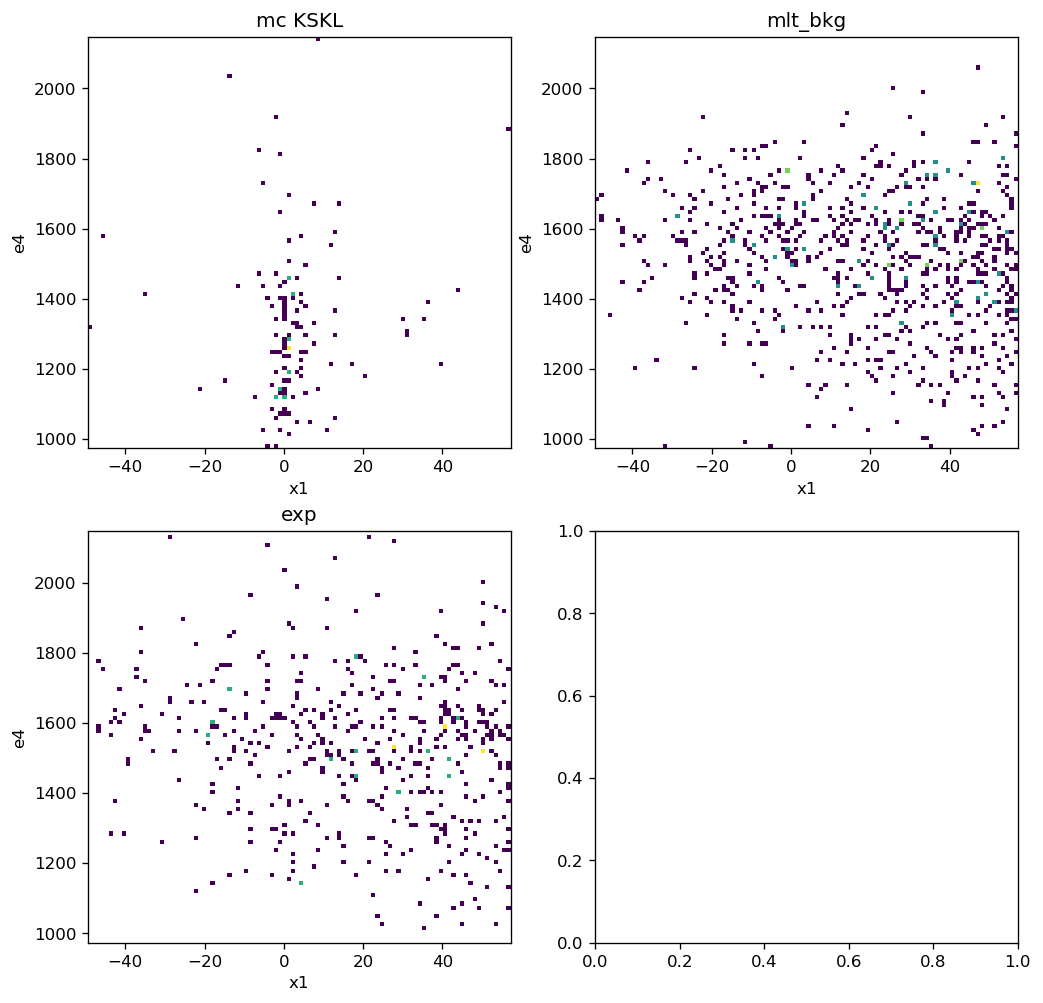

In [566]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

querystr = '(n==2)&(abs(x1)<70)'
dtemp = {}
for k in bm:
    dtemp[k] = bm[k].query(querystr).copy()
#     dtemp[k]['t1'] = np.abs((dtemp[k]['e4'] - 1600)/1600)
#     dtemp[k]['t2'] = (dtemp[k]['p4']/1600/2)
#     dtemp[k]['r'] = np.sqrt( dtemp[k]['t1']**2 + dtemp[k]['t2']**2 )
xval, yval = 'x1', 'e4'

rng = [[dtemp['mc'][xval].min(), dtemp['mc'][xval].max()], [dtemp['mc'][yval].min(), dtemp['mc'][yval].max()]]
ax = ax.ravel()
ax[0].hist2d(dtemp['mc'][xval], dtemp['mc'][yval], bins=100, cmin=1, range=rng, norm=mpl.colors.LogNorm())
ax[0].set(title='mc KSKL', xlabel=xval, ylabel=yval)
ax[1].hist2d(dtemp['mlt'].query('finalstate_id!=8')[xval].fillna(0), dtemp['mlt'].query('finalstate_id!=8')[yval], 
             bins=100, cmin=1, range=rng, norm=mpl.colors.LogNorm())
ax[1].set(title='mlt_bkg', xlabel=xval, ylabel=yval)
ax[2].hist2d(dtemp['exp'][xval], dtemp['exp'][yval], bins=100, cmin=1, range=rng, norm=mpl.colors.LogNorm())
ax[2].set(title='exp', xlabel=xval, ylabel=yval)
ax[3].text(0.01, 0.4, '');

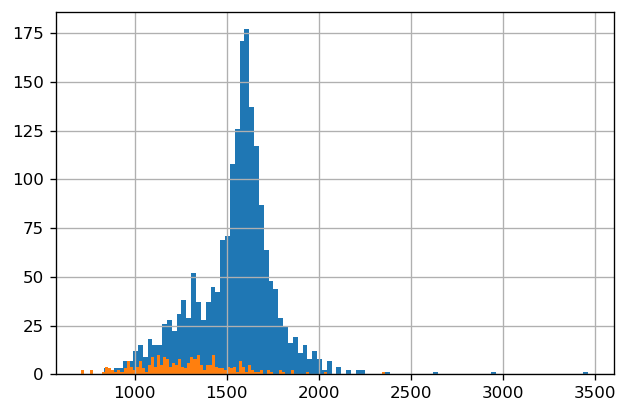

In [503]:
bm['exp']['total_en'].hist(bins=100);
bm['mc']['total_en'].hist(bins=100);

In [504]:
bm['mc']

minM          x1  finalstate_id         M1         M2  n  \
entry                                                                   
1      270.000000   -1.726286              0        NaN        NaN  0   
5      270.000000   -2.541116              0        NaN        NaN  0   
7      270.000000  147.962112              0        NaN        NaN  0   
8      270.000000    3.481315              0        NaN        NaN  0   
13     172.812683    2.981546              0  97.187317  97.187317  1   
...           ...         ...            ...        ...        ... ..   
19991  270.000000  153.157135              0        NaN        NaN  0   
19992  189.869049   -1.326566              0  80.130951  80.130951  1   
19993  270.000000    1.455303              0        NaN        NaN  0   
19996  270.000000   -6.893059              0        NaN        NaN  0   
19998  270.000000    4.732423              0        NaN        NaN  0   

           ksptot      ksth      ksminv  phen  total_en  
entry                                                    
1      667.915710  1.942385  512.218750   NaN       NaN  
5      630.549988  1.193242  496.580109   NaN       NaN  
7      269.144684  0.355450  515.618896   NaN       NaN  
8      624.666077  1.557787  500.730896   NaN       NaN  
13     600.814636  1.209409  490.770264   NaN       NaN  
...           ...       ...         ...   ...       ...  
19991  217.436752  2.283206  500.775787   NaN       NaN  
19992  651.701477  2.202400  506.242584   NaN       NaN  
19993  640.677979  1.459951  504.878510   NaN       NaN  
19996  644.358887  1.805650  497.356476   NaN       NaN  
19998  665.247742  1.442606  518.109192   NaN       NaN  

[6026 rows x 11 columns]

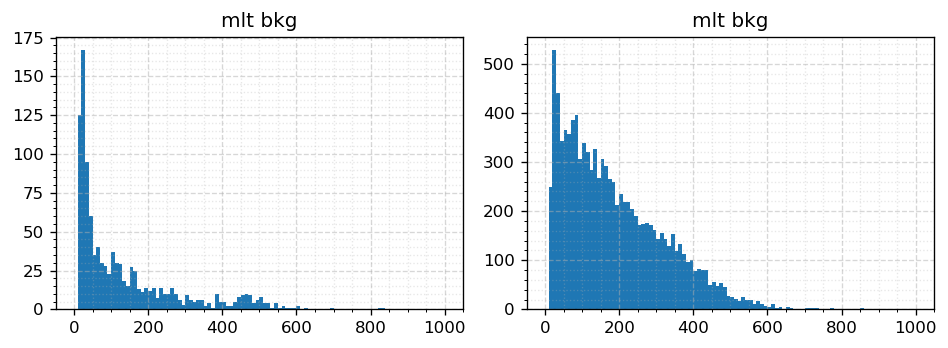

In [473]:
rng = (0, 1000)
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.hist( all_ph['mc'].phen, bins=100, range=rng );
pys.my_style('mlt bkg');

plt.subplot(122)
plt.hist( all_ph['mlt'].phen, bins=100, range=rng );
pys.my_style('mlt bkg');

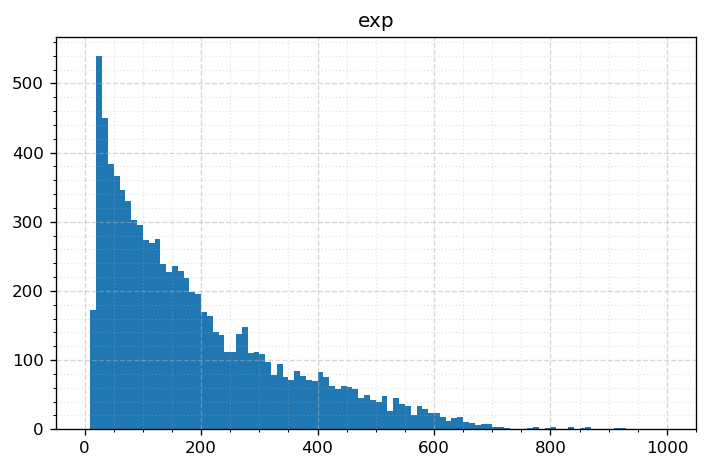

In [474]:
rng = (0, 1000)
plt.hist( all_ph['exp'].phen, bins=100, range=rng );
pys.my_style('exp');

In [414]:
# df1['mc']

ksalign    ksdpsi     kslen      ksminv     ksphi  \
entry subentry                                                       
8373  2         0.999986  1.249074  6.355381  517.469482  1.775239   
14517 0         0.960824  1.883534  0.950461  496.641632  4.441486   
17500 0         0.998814  1.206324  0.508385  502.303558  5.222735   
14795 11        0.999960  2.427492  1.872293  494.474091  2.273333   
8445  1         0.999897  1.243771  0.714872  505.330780  1.173867   
...                  ...       ...       ...         ...       ...   
19981 0         0.999910  1.537777  4.546734  490.559265  0.452171   
19991 0         0.890059  2.593254  0.212199  500.775787  3.071577   
19993 0         0.999988  1.356173  2.279415  504.878510  3.476629   
19996 0         0.999624  1.273506  1.628458  497.356476  5.989264   
19998 0         0.999205  1.248790  3.726437  518.109192  4.994394   

                    ksptot      ksth      ksz0      tdedx_n      tdedx_p  ...  \
entry subentry                                                            ...   
8373  2         677.207581  2.218539  4.196945  1819.677246  2740.192627  ...   
14517 0         298.889740  2.755674 -1.677436  1945.629639  2203.329590  ...   
17500 0         636.281921  1.670457 -2.324095  2151.024414  1825.118042  ...   
14795 11        327.686523  1.546090  0.583450  2055.616943  4146.135254  ...   
8445  1         632.574219  1.308068 -2.076738  2448.435303  2083.086182  ...   
...                    ...       ...       ...          ...          ...  ...   
19981 0         610.627502  1.189609 -5.236343  1998.000610  4166.553711  ...   
19991 0         217.436752  2.283206 -2.366230  2104.905273  4023.116211  ...   
19993 0         640.677979  1.459951  1.027264  2056.510986  2584.848877  ...   
19996 0         644.358887  1.805650 -0.846724  3347.663330  2531.804199  ...   
19998 0         665.247742  1.442606  3.484584  2069.099609  2437.057129  ...   

                        Px          Py          Pz           P           E  \
entry subentry                                                               
8373  2          -7.510838 -123.370316  153.713913  197.242523  239.019440   
14517 0         -86.956841  379.819885 -404.524323  561.662292  577.668396   
17500 0         -72.972542  174.490234  134.709427  232.203491  268.616364   
14795 11        101.660751   86.930077   85.910118  158.972626  208.496399   
8445  1        -137.262909   52.625313   73.183823  164.214508  212.697891   
...                    ...         ...         ...         ...         ...   
19981 0                NaN         NaN         NaN         NaN         NaN   
19991 0                NaN         NaN         NaN         NaN         NaN   
19993 0                NaN         NaN         NaN         NaN         NaN   
19996 0                NaN         NaN         NaN         NaN         NaN   
19998 0                NaN         NaN         NaN         NaN         NaN   

                         M    max_phen  argset  ideal_argset  len_intersect  
entry subentry                                                               
8373  2         135.002518  194.640442  {1, 2}        {1, 2}              0  
14517 0         135.041656  539.990295  {0, 1}        {0, 1}              0  
17500 0         135.041809  249.397491  {0, 1}        {0, 1}              0  
14795 11        134.901657  474.543091  {2, 3}        {2, 3}              0  
8445  1         135.181320  164.959412  {0, 2}        {0, 2}              0  
...                    ...         ...     ...           ...            ...  
19981 0                NaN         NaN     {0}           {0}              0  
19991 0                NaN         NaN     {0}           {0}              0  
19993 0                NaN         NaN     {0}           {0}              0  
19996 0                NaN         NaN     {0}           {0}              0  
19998 0                NaN         NaN     {0}           {0}              0  

[8800 rows x 50 column

<AxesSubplot:>

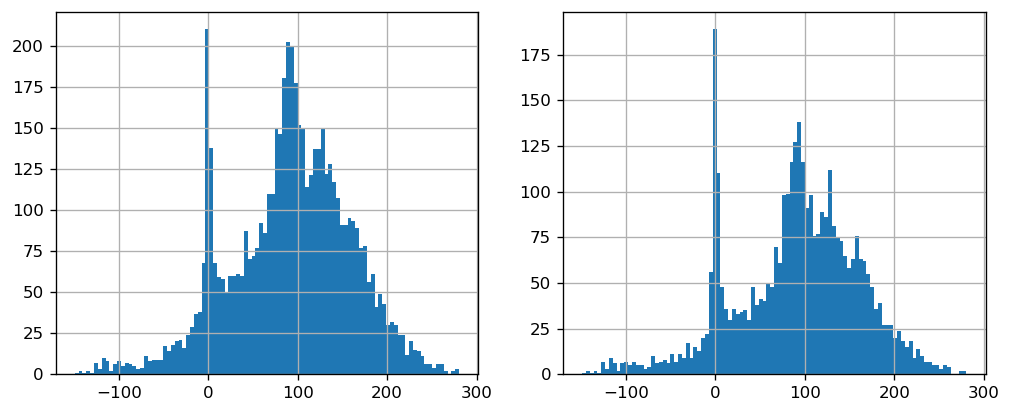

In [408]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
bm['exp'].x1.hist(bins=100)
plt.subplot(122)
bm['exp'].query('n<2').x1.hist(bins=100)

проверять относительную ошибку, если стала лучше, то ок, иначе думать

In [409]:
#без отбора
bm['mlt'].query('abs(x1)<50').finalstate_id.value_counts().head()

3     870
8     395
21     81
24     41
1      38
Name: finalstate_id, dtype: int64

In [410]:
#с отбором
bm['mlt'].query('(n<2)&(abs(x1)<50)').finalstate_id.value_counts().head()

8     383
3     282
21     50
1      35
11     16
Name: finalstate_id, dtype: int64

In [415]:
print('Потерял сигнала:', ((383 - 370)/383), 'Потерял 4пи:', ((395-282)/395)) 

Потерял сигнала: 0.033942558746736295 Потерял 4пи: 0.28607594936708863


Проверить этот отбор (на количество фотонов) на моделировании, меняется ли число событий в отношении

для событий, которые попали в картинку ниже, построить энергию всех фотонов, т.к. энергия от KL большая, а у pi0 маленькая (строил)

посмотреть энергию 4-х частиц, как в кин фите,
для трёх частиц смотреть массу отдачи

туда же, посмотреть 2d hist сумм энергия, сумм импульс

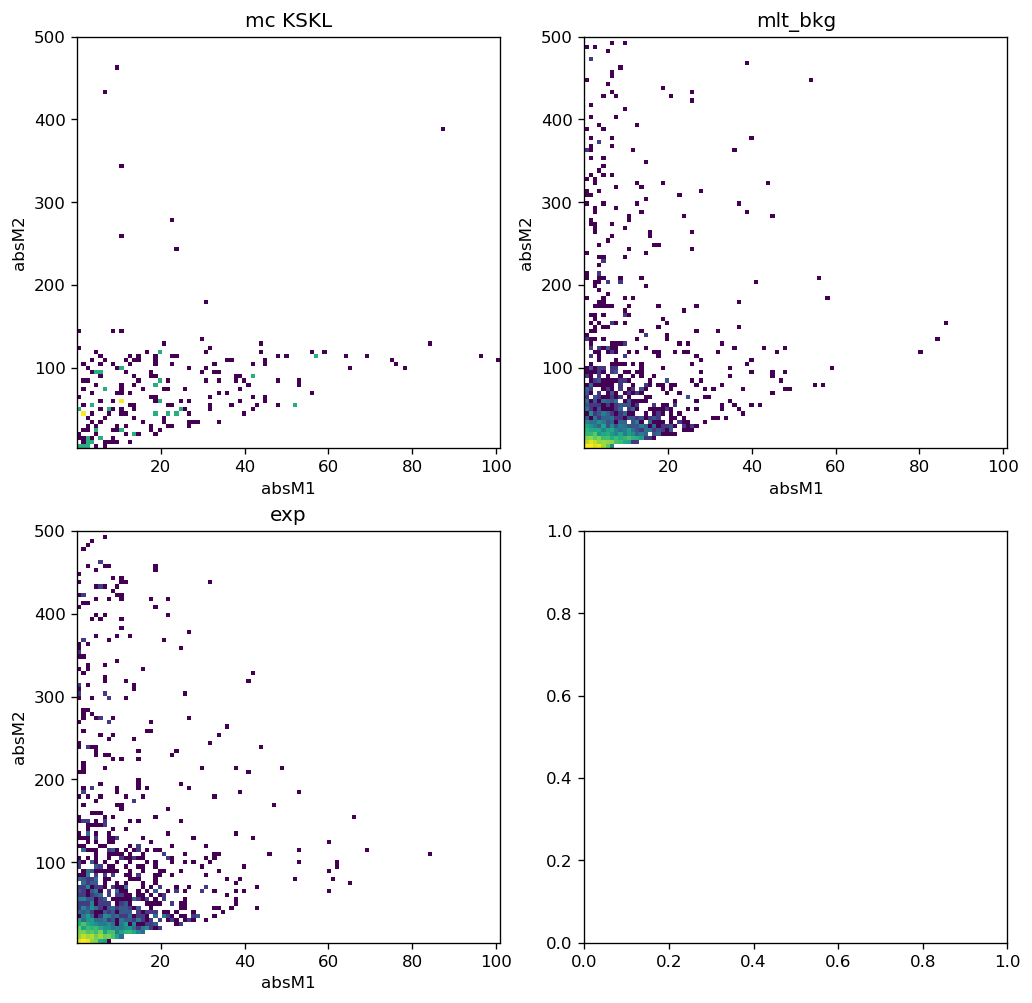

In [412]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

querystr = 'n==2'
dtemp = {}
for k in bm:
    dtemp[k] = bm[k].query(querystr).copy()
    dtemp[k]['absM1'] = np.abs(dtemp[k]['M1'] - 135)
    dtemp[k]['absM2'] = np.abs(dtemp[k]['M2'] - 135)
xval, yval = 'absM1', 'absM2'

rng = [[dtemp['mc'][xval].min(), dtemp['mc'][xval].max()], [dtemp['mc'][yval].min(), 500]]#dtemp['mc'][yval].max()]]
ax = ax.ravel()
ax[0].hist2d(dtemp['mc'][xval], dtemp['mc'][yval], bins=100, cmin=1, range=rng, norm=mpl.colors.LogNorm())
ax[0].set(title='mc KSKL', xlabel=xval, ylabel=yval)
ax[1].hist2d(dtemp['mlt'].query('finalstate_id!=8')[xval].fillna(0), dtemp['mlt'].query('finalstate_id!=8')[yval], 
             bins=100, cmin=1, range=rng, norm=mpl.colors.LogNorm())
ax[1].set(title='mlt_bkg', xlabel=xval, ylabel=yval)
ax[2].hist2d(dtemp['exp'][xval], dtemp['exp'][yval], bins=100, cmin=1, range=rng, norm=mpl.colors.LogNorm())
ax[2].set(title='exp', xlabel=xval, ylabel=yval)
ax[3].text(0.01, 0.4, '');

импульс двух нейтральных должен быть такой же как у двух заряженных, попробовать

посмотреть на кинематический фит

масса одного от массы другого

In [330]:
# bm['exp'].minM

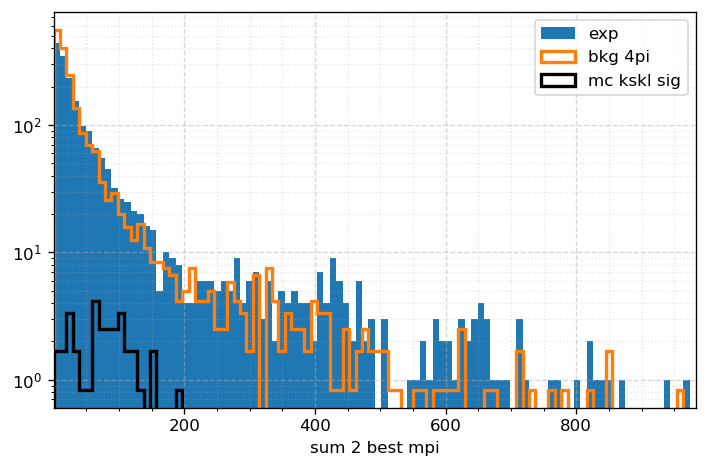

In [384]:
rng = (bm['mc'].minM.min(), bm['mc'].minM.max())
plt.hist( bm['exp'].query('n==2').minM, bins=100, range=rng, label='exp')
dd = bm['mc'].query('(n==2)&(finalstate_id!=8)').minM
w = len(bm['exp'].query('(n==2)'))/len(bm['mlt'].query('(n==2)'))
ddmlt = bm['mlt'].query('(n==2)&(finalstate_id!=8)').minM
ddsig = bm['mlt'].query('(n==2)&(finalstate_id==8)').minM
dat = plt.hist(ddmlt, bins=100, range=rng, label='bkg 4pi', histtype='step', lw=2, weights=np.ones_like(ddmlt)*w)
datsig = plt.hist(ddsig, bins=100, range=rng, label='mc kskl sig', histtype='step', lw=2, weights=np.ones_like(ddsig)*w, color='black')
# dat = plt.hist( dd, bins=100, range=rng, label='mc kskl', histtype='step', lw=2, hatch='//',
#         weights=np.ones_like(dd)*0.3)
plt.legend();
plt.yscale('log');
pys.my_style(xlim=rng, xtitle='sum 2 best mpi');
# best_mass['mc'].query('finalstate_id!=8').groupby('entry').agg(sumM=('M', 'sum')).hist(bins=100)

In [151]:
# best_mass['exp']

In [152]:
best_mass['exp'].columns

Index(['ksalign', 'ksdpsi', 'kslen', 'ksminv', 'ksphi', 'ksptot', 'ksth',
       'ksz0', 'tdedx_n', 'tdedx_p', 'tphi_n', 'tphi_p', 'tptot_n', 'tptot_p',
       'trho_n', 'trho_p', 'tth_n', 'tth_p', 'tz_n', 'tz_p', 'ebeam', 'emeas',
       'lumoff', 'lumofferr', 'runnum', 'finalstate_id', 'badrun', 'x1', 'x2',
       'recoil', 'px0', 'px1', 'py0', 'py1', 'pz0', 'pz1', 'E0', 'E1', 'Px',
       'Py', 'Pz', 'P', 'E', 'M', 'max_phen'],
      dtype='object')

In [55]:
# fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# ax = ax.ravel()
# dtemp = {}
# for i, k in enumerate(best_mass):
#     dtemp[k] = best_mass[k].fillna(0).query('(recoil>0)&(M<50)')
#     x = dtemp[k].phen
#     y = dtemp[k].ksphi
#     ax[i].hist2d(x, y, bins=100, cmin=1)
#     ax[i].set(title=k)
# # ax[3].text(0.01, 0.4, 'Инвариантная масса всех пар фотонов');

In [119]:
# dd = df1['exp']
for k in df1:
#     dd = df1[k]
    m2g = vector.array({
        'px' : df1[k]['Px'],
        'py' : df1[k]['Py'],
        'pz' : df1[k]['Pz'],
        'mass' : df1[k]['M'],
    })
    m2p = vector.array({
        'pt' : df1[k]['ksptot'] * np.sin(df1[k]['ksth']),
        'theta' : df1[k]['ksth'],
        'phi' : df1[k]['ksphi'],
        'mass' : df1[k]['ksminv'],
    })
    df1[k]['omegaM'] = (m2p + m2g).mass

In [144]:
# df1['mlt'].query('finalstate_id!=8')['M'].hist(bins=100)

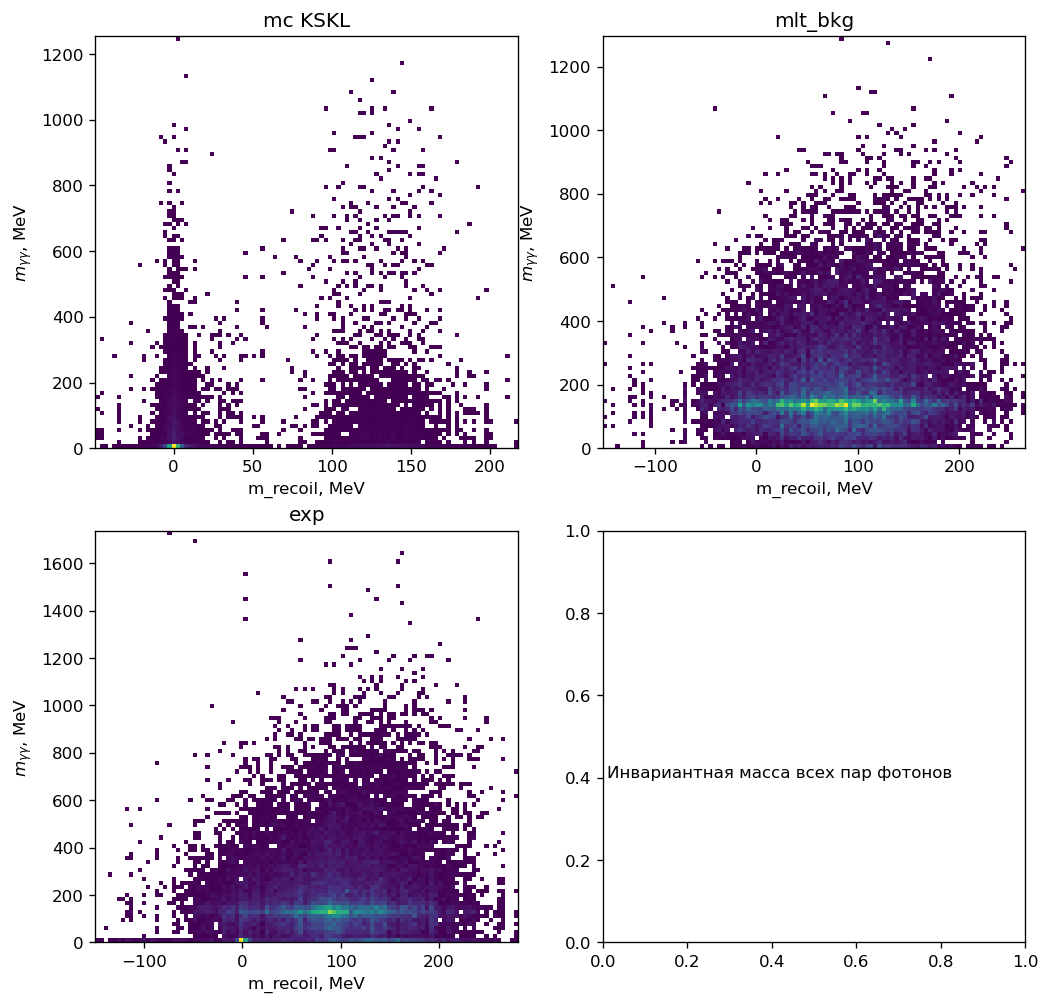

In [149]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].hist2d(df1['mc'].x1, df1['mc'].M.fillna(0), bins=100, cmin=1)
ax[0].set(title='mc KSKL', xlabel='m_recoil, MeV', ylabel='$m_{\gamma\gamma}$, MeV')
ax[1].hist2d(df1['mlt'].query('finalstate_id!=8').x1, df1['mlt'].query('finalstate_id!=8').M.fillna(0), bins=100, cmin=1)
ax[1].set(title='mlt_bkg', xlabel='m_recoil, MeV', ylabel='$m_{\gamma\gamma}$, MeV')
ax[2].hist2d(df1['exp'].x1, df1['exp'].M.fillna(0), bins=100, cmin=1)
ax[2].set(title='exp', xlabel='m_recoil, MeV', ylabel='$m_{\gamma\gamma}$, MeV')
ax[3].text(0.01, 0.4, 'Инвариантная масса всех пар фотонов');
# for a in ax[:-1]:
#     a.set_yscale('log')

проверить omega

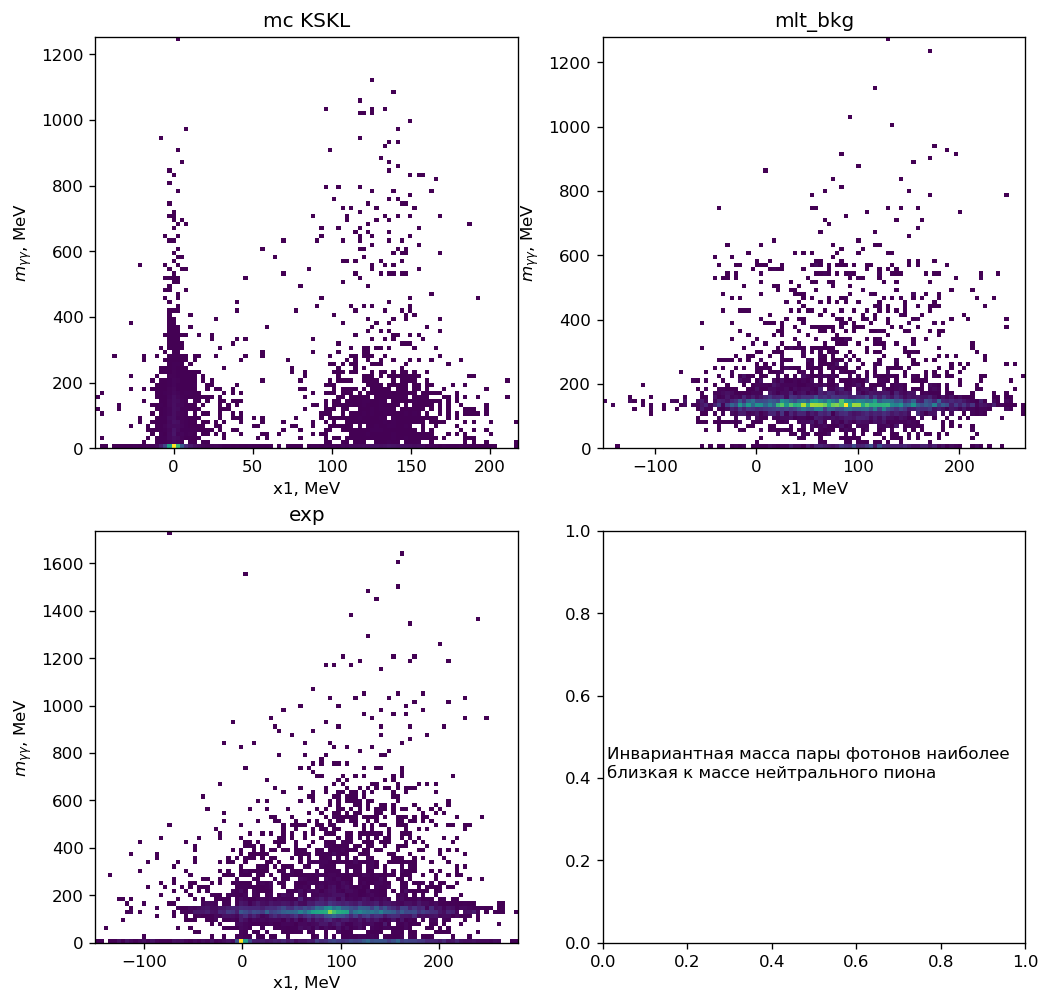

In [153]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
dmc = best_mass['mc']#.dropna()
ax[0].hist2d(dmc.x1, dmc.M.fillna(0), bins=100, cmin=1)
ax[0].set(title='mc KSKL', xlabel='x1, MeV', ylabel='$m_{\gamma\gamma}$, MeV')
ax[1].hist2d(best_mass['mlt'].query('finalstate_id!=8').x1, best_mass['mlt'].query('finalstate_id!=8').M.fillna(0), bins=100, cmin=1)
ax[1].set(title='mlt_bkg', xlabel='x1, MeV', ylabel='$m_{\gamma\gamma}$, MeV')
ax[2].hist2d(best_mass['exp'].x1, best_mass['exp'].M.fillna(0), bins=100, cmin=1)
ax[2].set(title='exp', xlabel='x1, MeV', ylabel='$m_{\gamma\gamma}$, MeV')
ax[3].text(0.01, 0.4, 'Инвариантная масса пары фотонов наиболее\nблизкая к массе нейтрального пиона');

In [106]:
# rng, bins = (0, 600), 100
# plt.hist(best_mass['exp'].fillna(0).M, bins=bins, range=rng, histtype='step');
# bm = best_mass['mlt'].fillna(0).query('(finalstate_id!=8)').M
# plt.hist(bm, bins=bins, range=rng, histtype='step', weights=np.ones_like(bm)*0.6);

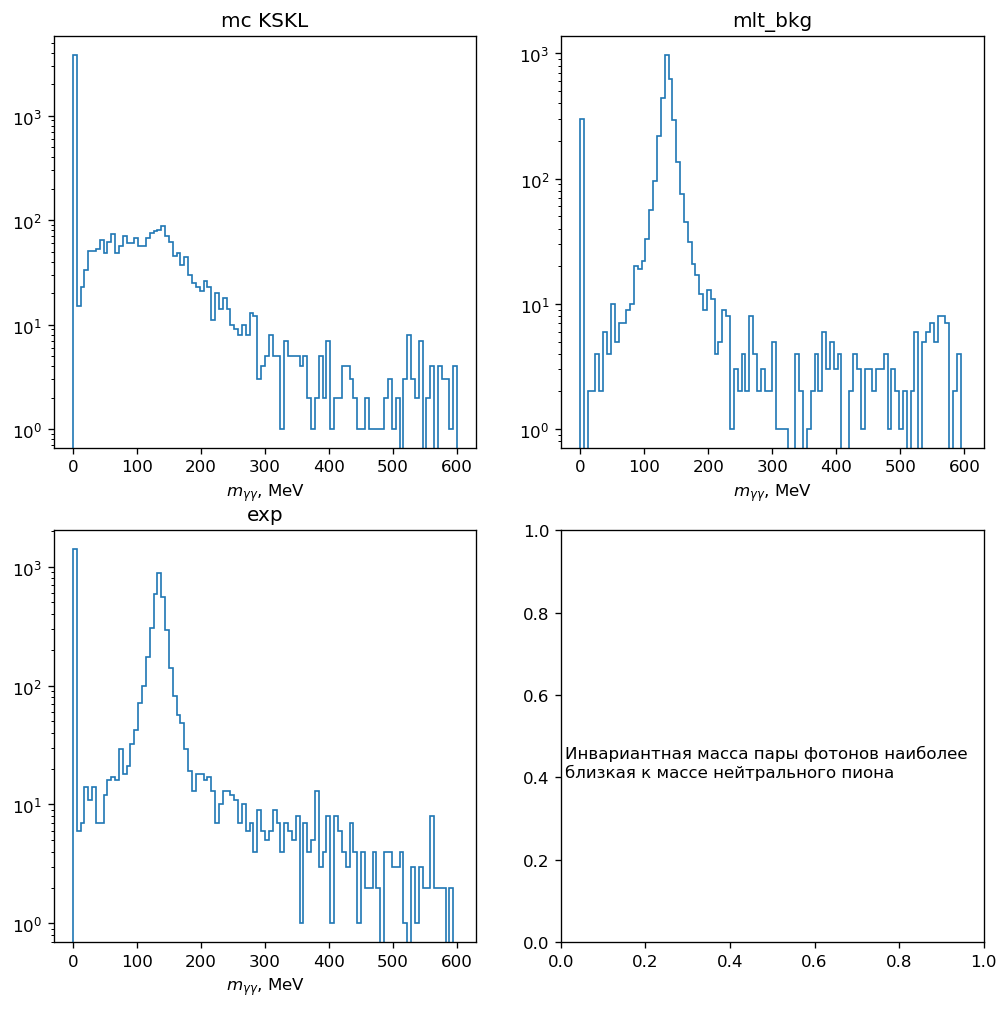

In [97]:
rng, bins = (0, 600), 100
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].hist(best_mass['mc'].M.fillna(0), bins=bins, range=rng, histtype='step')
ax[0].set(title='mc KSKL', xlabel='$m_{\gamma\gamma}$, MeV')
ax[1].hist(best_mass['mlt'].query('finalstate_id!=8').M.fillna(0), bins=bins, range=rng, histtype='step')
ax[1].set(title='mlt_bkg', xlabel='$m_{\gamma\gamma}$, MeV')
ax[2].hist(best_mass['exp'].M.fillna(0), bins=bins, range=rng, histtype='step')
ax[2].set(title='exp', xlabel='$m_{\gamma\gamma}$, MeV')
ax[3].text(0.01, 0.4, 'Инвариантная масса пары фотонов наиболее\nблизкая к массе нейтрального пиона');

for a in ax[:-1]:
    a.set_yscale('log')

кат на 50 МэВ кажется оптимальным

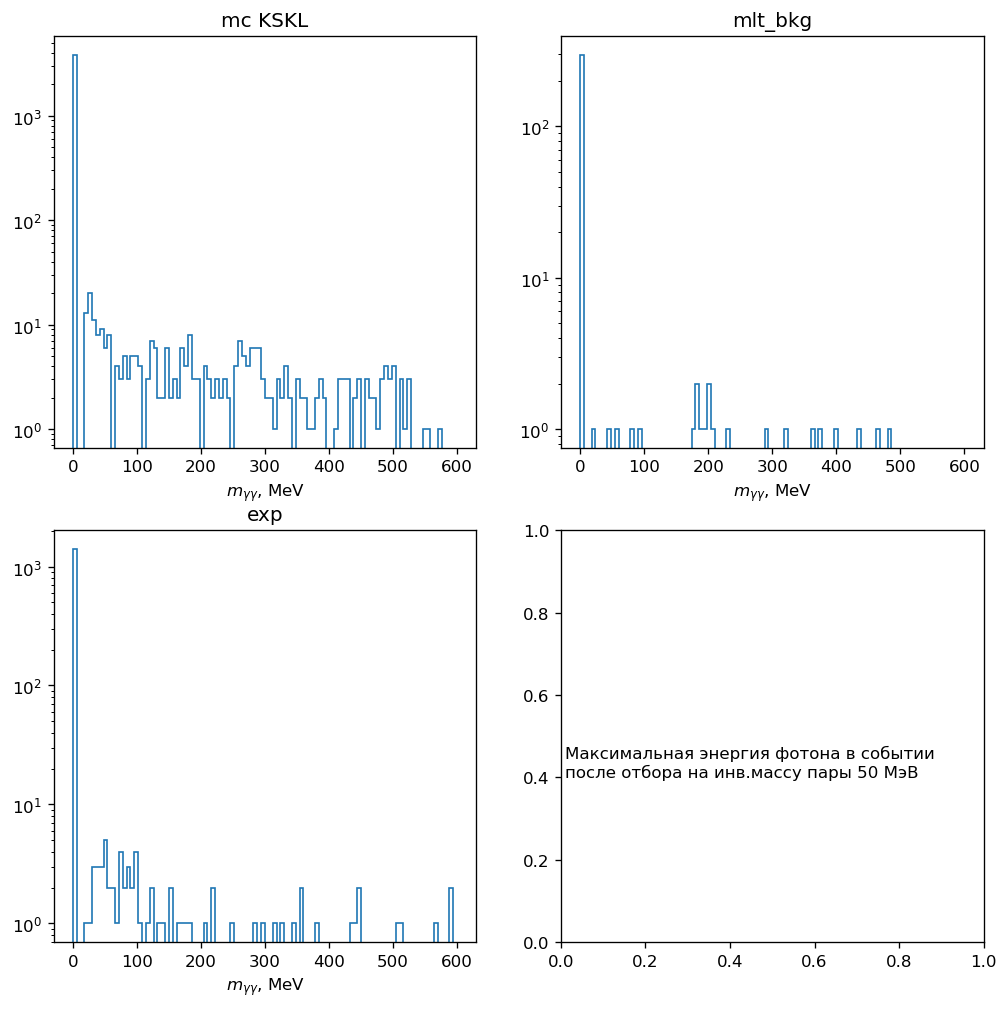

In [78]:
rng, bins = (0, 600), 100
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].hist(best_mass['mc'].fillna(0).query('M<50').max_phen, bins=bins, range=rng, histtype='step')
ax[0].set(title='mc KSKL', xlabel='$m_{\gamma\gamma}$, MeV')
ax[1].hist(best_mass['mlt'].fillna(0).query('(M<50)&(finalstate_id!=8)').max_phen, bins=bins, range=rng, histtype='step')
ax[1].set(title='mlt_bkg', xlabel='$m_{\gamma\gamma}$, MeV')
ax[2].hist(best_mass['exp'].fillna(0).query('M<50').max_phen, bins=bins, range=rng, histtype='step')
ax[2].set(title='exp', xlabel='$m_{\gamma\gamma}$, MeV')
ax[3].text(0.01, 0.4, 'Максимальная энергия фотона в событии\nпосле отбора на инв.массу пары 50 МэВ');
for a in ax[:-1]:
    a.set_yscale('log')

In [79]:
# plt.hist2d?

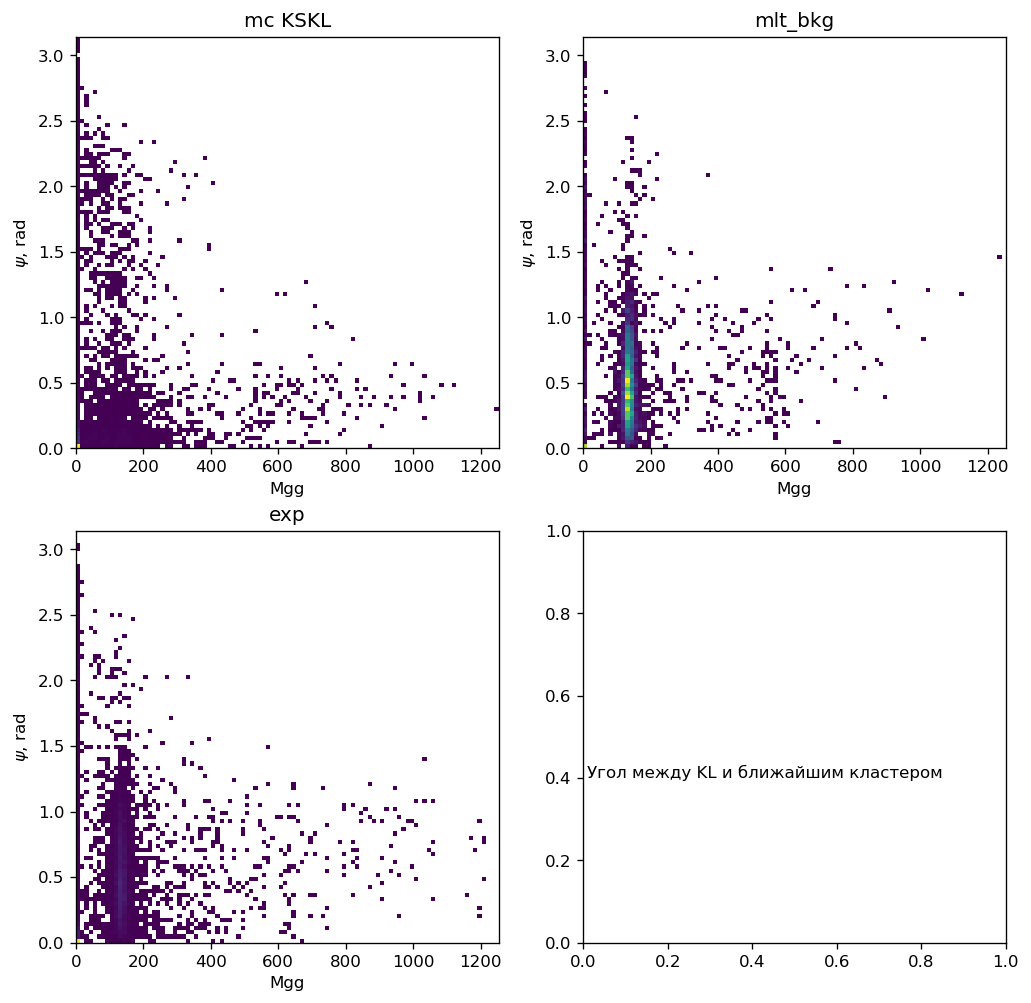

In [189]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ylabel = '$\psi$, rad'
xlabel = 'Mgg'

dtemp = {}
for k in best_mass:
    dtemp[k] = best_mass[k].fillna(0)#.query('M<50')

rng = [[0, dtemp['mc'].M.max()], [0, np.pi]]
ax = ax.ravel()
ax[0].hist2d(dtemp['mc'].M, dtemp['mc'].ang, bins=100, cmin=1, range=rng)
ax[0].set(title='mc KSKL', xlabel=xlabel, ylabel=ylabel)
ax[1].hist2d(dtemp['mlt'].query('finalstate_id!=8').M.fillna(0), dtemp['mlt'].query('finalstate_id!=8').ang, bins=100, cmin=1, range=rng)
ax[1].set(title='mlt_bkg', xlabel=xlabel, ylabel=ylabel)
ax[2].hist2d(dtemp['exp'].M, dtemp['exp'].ang, bins=100, cmin=1, range=rng)
ax[2].set(title='exp', xlabel=xlabel, ylabel=ylabel)
ax[3].text(0.01, 0.4, 'Угол между KL и ближайшим кластером');

In [24]:
# rng, bins = (-200, 200), 100
# fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# ax = ax.ravel()
# ax[0].hist(best_mass['mc'].query('recoil<0').x1, bins=bins, range=rng, histtype='step')
# ax[0].set(title='mc KSKL', xlabel='$m_{\gamma\gamma}$, MeV')
# ax[1].hist(best_mass['mlt'].query('(recoil<0)&(finalstate_id!=8)').x1, bins=bins, range=rng, histtype='step')
# ax[1].set(title='mlt_bkg', xlabel='$m_{\gamma\gamma}$, MeV')
# ax[2].hist(best_mass['exp'].query('recoil<0').x1, bins=bins, range=rng, histtype='step')
# ax[2].set(title='exp', xlabel='$m_{\gamma\gamma}$, MeV')
# ax[3].text(0.01, 0.4, 'Максимальная энергия фотона в событии\nпосле отбора на инв.массу пары 50 МэВ');
# # for a in ax[:-1]:
# #     a.set_yscale('log')

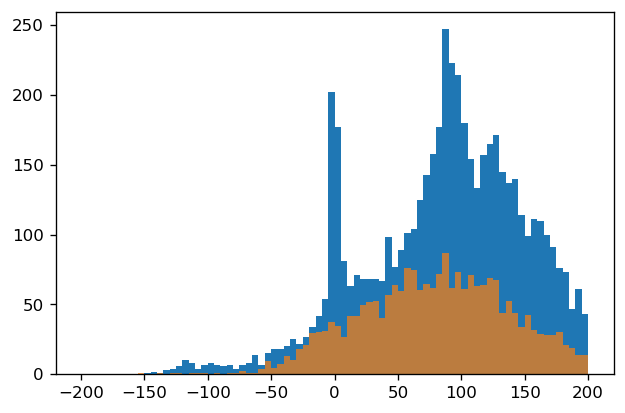

In [104]:
bins0, rng0 = 80, (-200, 200)
plt.hist(best_mass['exp'].fillna(0).x1, bins=bins0, range=rng0);
mlt_dat = best_mass['mlt'].fillna(0).query('(finalstate_id!=8)').x1
plt.hist(mlt_dat, bins=bins0, range=rng0, alpha=0.7, weights=np.ones_like(mlt_dat)*0.6);
# plt.hist(best_mass['kkp'].fillna(0).query('(M<20)').x1, bins=bins0, range=rng0);

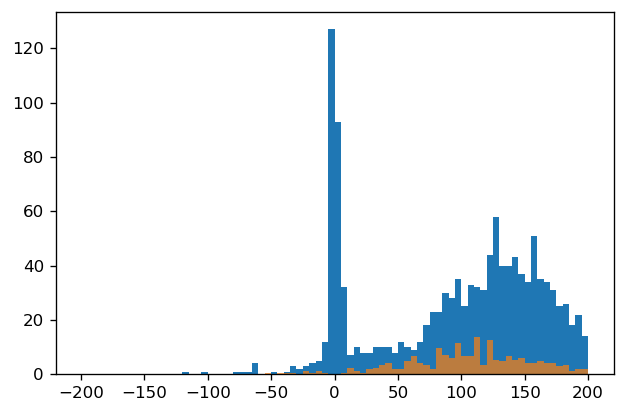

In [105]:
bins0, rng0 = 80, (-200, 200)
plt.hist(best_mass['exp'].fillna(0).query('(M<50)&(recoil>0)').x1, bins=bins0, range=rng0);
mlt_dat = best_mass['mlt'].fillna(0).query('(M<50)&(recoil>0)&(finalstate_id!=8)').x1
bkg = plt.hist(mlt_dat, bins=bins0, range=rng0, alpha=0.7, weights=np.ones_like(mlt_dat)*0.6);
sig_mc = best_mass['mlt'].fillna(0).query('(M<50)&(recoil>0)&(finalstate_id==8)').x1
# plt.hist(sig_mc, weights=np.ones_like(sig_mc)*2.2, 
#          bottom=bkg[0], bins=bins0, range=rng0, alpha=0.7);
# plt.hist(best_mass['kkp'].fillna(0).query('(M<20)').x1, bins=bins0, range=rng0);

In [317]:
# plt.hist(best_mass['kkp'].fillna(0).query('(M<50)&(finalstate_id!=8)&(recoil>0)').x1, bins=bins0, range=rng0);

In [27]:
# plt.hist(best_mass['mlt'].fillna(0).query('(M<50)&(finalstate_id!=8)&(recoil>0)').x1, bins=bins0, range=rng0);

In [ ]:
plt.hist(best_mass['mc'].fillna(0).query('(M<50)&(recoil>0)').x1, bins=100);

In [63]:
df1['mc'].index.droplevel(1).nunique()

3153

In [64]:
df1['mc'].tail()

px0         px1         py0         py1         pz0  \
entry subentry                                                               
19974 0         158.742645  -49.857952   34.039867   -1.620115 -259.861542   
19976 0         129.131927 -140.175247  -66.981895   57.239185  144.004044   
19989 0        -135.448944   83.533119   77.107002 -103.595558  -98.783936   
      1        -135.448944   10.660468   77.107002  -43.871914  -98.783936   
      2          83.533119   10.660468 -103.595558  -43.871914  104.296844   

                       pz1          E0          E1          Px          Py  \
entry subentry                                                               
19974 0          65.144348  306.408142   82.050140  108.884689   32.419754   
19976 0          39.468731  204.691940  156.471100  -11.043320   -9.742710   
19989 0         104.296844  184.526901  169.078827  -51.915825  -26.488556   
      1          36.556992  184.526901   58.093063 -124.788475   33.235088   
      2          36.556992  169.078827   58.093063   94.193588 -147.467468   

                ...       ebeam       emeas  lumoff  lumofferr  runnum  \
entry subentry  ...                                                      
19974 0         ...  624.611511  624.611511     0.0        0.0       0   
19976 0         ...  624.611511  624.611511     0.0        0.0       0   
19989 0         ...  624.611511  624.611511     0.0        0.0       0   
      1         ...  624.611511  624.611511     0.0        0.0       0   
      2         ...  624.611511  624.611511     0.0        0.0       0   

                finalstate_id  badrun          x1          x2      recoil  
entry subentry                                                             
19974 0                     0   False  137.570343 -227.633636  728.793030  
19976 0                     0   False  110.640587 -186.678238  708.585144  
19989 0                     0   False  156.734024 -256.378113  737.903870  
      1                     0   False  156.734024 -256.378113  737.903870  
      2                     0   False  156.734024 -256.378113  737.903870  

[5 rows x 44 columns]

<AxesSubplot:>

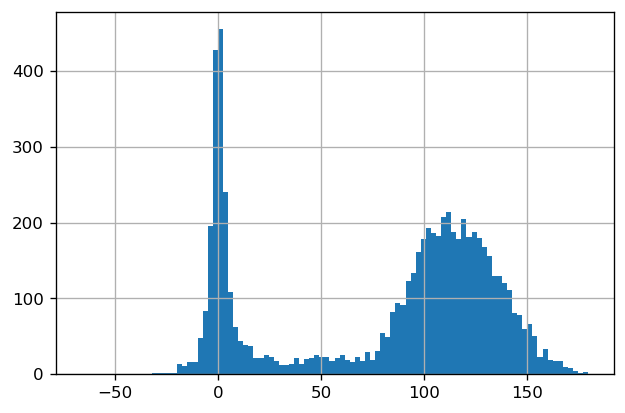

In [26]:
df['mc'].drop_duplicates(subset=['ksminv'], keep='first').x1.hist(bins=100)

<AxesSubplot:>

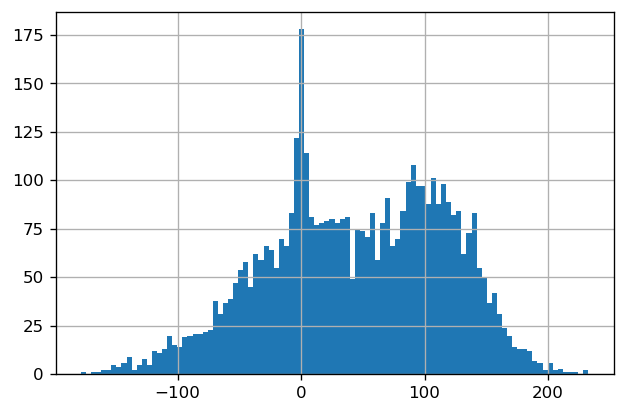

In [18]:
df['exp'].drop_duplicates(subset=['ksminv'], keep='first').x1.hist(bins=100)

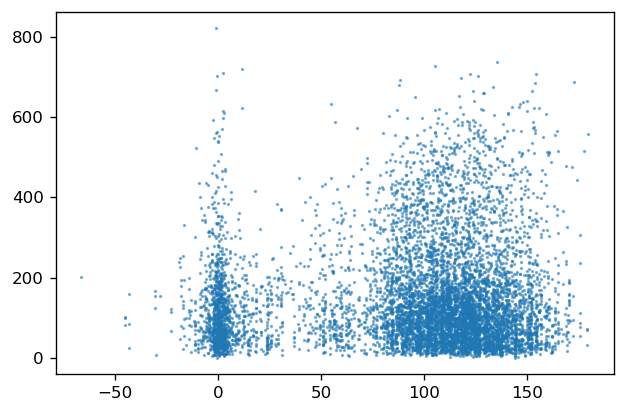

In [249]:
dd = df['mc'].join(ph['mc'])
plt.scatter(dd.x1, dd.M, s=1, alpha=0.5)

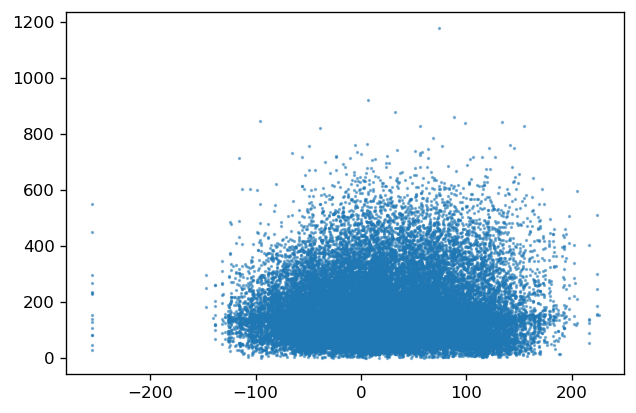

In [247]:
dd = df['mlt'].join(ph['mlt'])
plt.scatter(dd.x1, dd.M, s=1, alpha=0.5)

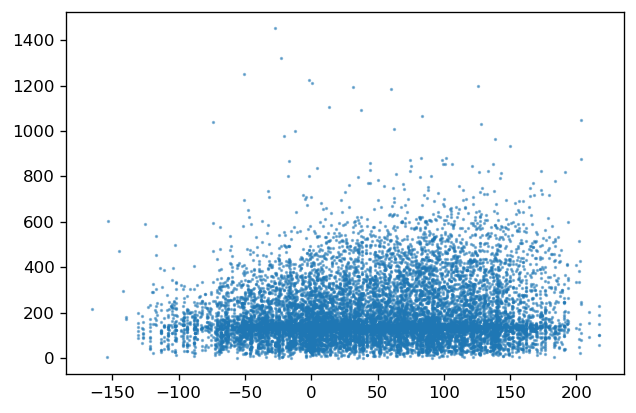

In [248]:
dd = df['exp'].join(ph['exp'])
plt.scatter(dd.x1, dd.M, s=1, alpha=0.5)

In [239]:
ph['exp']

px0        px1         py0         py1         pz0  \
entry    subentry                                                              
0        0         236.821594  -1.503772  227.865372  -16.699797  567.541077   
1378     0        -217.049667 -73.093918  270.258392 -179.426346   61.104553   
         1        -217.049667  32.863720  270.258392   91.436508   61.104553   
         2         -73.093918  32.863720 -179.426346   91.436508 -145.960297   
2079     0          51.385357 -29.363232  -43.184757   -3.386228  129.453796   
...                       ...        ...         ...         ...         ...   
11695621 9         -72.252602   5.933632    4.222839    6.595829   35.902298   
11696280 0         177.664169 -44.906109   56.938297  -14.841686  174.337311   
11696810 0        -281.808319   5.390193  368.749847  -15.230390 -291.895172   
         1        -281.808319 -15.228432  368.749847  -20.878242 -291.895172   
         2           5.390193 -15.228432  -15.230390  -20.878242  -58.182697   

                          pz1          E0          E1          Px          Py  \
entry    subentry                                                               
0        0         -37.865242  655.827698   41.411606  235.317825  211.165573   
1378     0        -145.960297  351.971466  242.571533 -290.143585   90.832047   
         1         -19.344610  351.971466   99.070045 -184.185944  361.694885   
         2         -19.344610  242.571533   99.070045  -40.230198  -87.989838   
2079     0          72.528564  145.820663   78.320236   22.022125  -46.570984   
...                       ...         ...         ...         ...         ...   
11695621 9          21.924328   80.791374   23.651409  -66.318970   10.818668   
11696280 0          27.541235  255.342957   54.729824  132.758057   42.096611   
11696810 0         -58.182697  548.265625   60.384148 -276.418121  353.519470   
         1         -28.464689  548.265625   38.445347 -297.036743  347.871613   
         2         -28.464689   60.384148   38.445347   -9.838240  -36.108631   

                           Pz           P           E           M  
entry    subentry                                                  
0        0         529.675842  616.864563  697.239319  324.993500  
1378     0         -84.855743  315.648956  594.542969  503.832397  
         1          41.759941  408.033752  451.041504  192.215744  
         2        -165.304901  191.536911  341.641571  282.900299  
2079     0         201.982361  208.448334  224.140900   82.391975  
...                       ...         ...         ...         ...  
11695621 9          57.826626   88.651947  104.442780   55.218895  
11696280 0         201.878540  245.258591  310.072784  189.719147  
11696810 0        -350.077881  569.155090  608.649780  215.678070  
         1        -320.359863  558.458557  586.710999  179.871658  
         2         -86.647385   94.384285   98.829498   29.306585  

[68666 rows x 14 columns]

In [231]:
ak.to_list(vecs[1])

{'rho': [], 'phi': [], 'theta': [], 'tau': []}

In [155]:
a0 = tr['mc'].arrays(['evnum', 'pt', 'theta', 'phi', 'mass'], cut='(nt>=2)&(nks>0)', aliases={'pt': 'phen*sin(phth)', 'theta': 'phth', 
                                                                      'phi': 'phphi', 'mass': '0*phen'})

In [157]:
ak.to_pandas(a0)

evnum          pt     theta       phi  mass
entry subentry                                             
0     0             0  240.711929  2.271679  6.153927   0.0
1     0             4   37.082996  2.733097  5.964041   0.0
      1             4   21.326807  2.777692  1.471514   0.0
      2             4   45.513783  0.917110  4.683267   0.0
      3             4   19.110584  2.373325  2.216912   0.0
...               ...         ...       ...       ...   ...
9553  3         19987   56.881737  1.799070  0.459262   0.0
9554  0         19989  155.858612  2.135702  2.624075   0.0
      1         19989  133.078247  0.906058  5.390983   0.0
      2         19989   45.148537  0.890166  4.950760   0.0
9555  0         19990   35.958900  2.739930  2.196975   0.0

[15653 rows x 5 columns]

In [154]:
ak.to_pandas(arrs)

pt     theta       phi  mass
entry subentry                                      
0     0         240.711929  2.271679  6.153927   0.0
1     0          37.082996  2.733097  5.964041   0.0
      1          21.326807  2.777692  1.471514   0.0
      2          45.513783  0.917110  4.683267   0.0
      3          19.110584  2.373325  2.216912   0.0
...                    ...       ...       ...   ...
10582 2          45.148537  0.890166  4.950760   0.0
10583 0          35.958900  2.739930  2.196975   0.0
10584 0          49.538399  1.583814  1.244836   0.0
      1           9.219747  2.680696  6.080773   0.0
10586 0         231.828354  0.659284  4.544816   0.0

[18384 rows x 4 columns]

In [148]:
df['mc']

ksalign    ksdpsi     kslen      ksminv     ksphi      ksptot  \
entry                                                                   
0      0.979831  2.598839  0.499601  500.424744  2.903628  163.391220   
4      0.998714  2.390845  1.967979  502.450623  3.962540  167.034119   
10     0.998094  2.387803  1.336799  496.927399  3.730610  177.920273   
22     0.998731  2.263732  0.404150  504.804474  3.213228  197.831100   
27     0.999865  2.835792  1.090541  503.043518  3.115674  113.631508   
...         ...       ...       ...         ...       ...         ...   
19982  0.989382  2.787826  0.064022  501.845032  0.980342  242.059113   
19983  0.999985  2.387388  3.009969  497.305664  4.026163  222.736526   
19989  0.969435  2.910324  0.771272  501.316467  0.635783   77.067665   
19990  0.999961  2.578182  0.572448  492.207977  5.914096  205.812759   
19996  0.992744  1.752260  0.110200  495.409668  2.035114  363.274841   

           ksth      ksz0      tdedx_n      tdedx_p  ...      tz_p  \
entry                                                ...             
0      2.033804  3.262710  2658.981689  2300.115723  ...  2.885131   
4      2.490387  1.801664  2357.307129  1865.273315  ...  0.236562   
10     0.660722  1.810488  2773.072754  1980.308960  ...  1.809698   
22     1.637009  0.655012  2054.685303  1816.073853  ...  0.678337   
27     1.199001  5.423531  2124.125244  2959.384033  ...  5.415817   
...         ...       ...          ...          ...  ...       ...   
19982  1.357613  2.285592  1618.816040  3734.450684  ...  2.197684   
19983  1.293532 -1.739963  2941.030762  3363.445557  ... -0.808240   
19989  1.654012  3.360199  2664.052002  2395.802979  ...  2.787129   
19990  2.113116 -1.695634  2151.795898  3568.814697  ... -1.709181   
19996  1.355729 -3.234771  1773.054932  2636.559082  ... -3.114579   

            ebeam       emeas  lumoff  lumofferr  runnum  finalstate_id  \
entry                                                                     
0      624.611511  624.611511     0.0        0.0       0              0   
4      624.611511  624.611511     0.0        0.0       0              0   
10     624.611511  624.611511     0.0        0.0       0              0   
22     624.611511  624.611511     0.0        0.0       0              0   
27     624.611511  624.611511     0.0        0.0       0              0   
...           ...         ...     ...        ...     ...            ...   
19982  624.611511  624.611511     0.0        0.0       0              0   
19983  624.611511  624.611511     0.0        0.0       0              0   
19989  624.611511  624.611511     0.0        0.0       0              0   
19990  624.611511  624.611511     0.0        0.0       0              0   
19996  624.611511  624.611511     0.0        0.0       0              0   

       badrun          x1          x2  
entry                                  
0       False  111.856216 -182.631714  
4       False  111.736099 -178.465118  
10      False  101.425621 -171.929947  
22      False   98.022186 -150.789795  
27      False  139.534454 -224.066025  
...       ...         ...         ...  
19982   False   72.877800 -114.284523  
19983   False   78.849686 -133.213455  
19989   False  156.734024 -256.378113  
19990   False   83.115845 -150.365723  
19996   False    5.404898  -13.378259  

[6717 rows x 29 columns]

In [139]:
ak.to_pandas(arrs[[77, 78]])

pt     theta       phi  mass
entry subentry                                     
0     0         91.678482  0.425876  2.004162   0.0
      1         17.566530  1.514900  2.699904   0.0

In [531]:
df['mlt'] = df['mlt'].query('finalstate_id!=8')

In [532]:
def pairmass(dat='mc'):
    photons = ak.to_pandas(tr[dat].arrays(['phen', 'phth', 'phphi', 'phen0', 'phth0', 'phphi0'], cut='nph>1'))
    photons['pt'] = photons['phen']*np.sin(photons['phth'])
    photons = photons.loc[photons.index.get_level_values(0).intersection(df[dat].index), :]
    pairs_inv_masses = photons.groupby('entry').apply(lambda x: comp_mass(x))
#     pairs_inv_masses = pairs_inv_masses.append(pd.Series(0, index=df[dat].index.difference(photons.index.get_level_values(0))))
    pairs_inv_masses.name = 'minv2p'
    thetas_clusters = photons.groupby('entry').apply(lambda x: x['phth0']) #использую ...0, т.к. собираюсь определять угол между кластером
    thetas_clusters.name = 'cl_th'
    phis_clusters = photons.groupby('entry').apply(lambda x: x['phphi0'])
    phis_clusters.name = 'cl_ph'
    en_clusters = photons.groupby('entry').apply(lambda x: x['phen0'])
    en_clusters.name = 'cl_en'
    return (pairs_inv_masses, thetas_clusters, phis_clusters, en_clusters)

In [533]:
import vector

In [534]:
# photons = {}
dat = 'mc'
photons[dat] = ak.to_pandas(tr[dat].arrays(['phen', 'phth', 'phphi'], cut='nph>1'))
photons[dat]['pt'] = photons[dat]['phen']*np.sin(photons[dat]['phth'])

In [535]:
photons[dat] = photons[dat].loc[photons[dat].index.get_level_values(0).intersection(df[dat].index), :]

In [536]:
from itertools import combinations

In [537]:
# pairs_inv_masses = {}

In [538]:
def comp_mass(df):
    v = vector.array(
    {
        'pt' : df['pt'],
        'theta' : df['phth'],
        'phi' : df['phphi'],
        'mass' : np.zeros_like(df['pt']),
    })
    v0 = vector.obj(px=0, py=0, pz=0, E=625*2)
#     m, recoil = np.inf, np.inf
    m = []
    for i, j in combinations(range(len(v)), 2):
        m_candidate = (v[i] + v[j])
        m.append(m_candidate.mass)
#         m = m_candidate.mass if np.abs( m_candidate.mass - 135 ) < np.abs( m - 135 ) else m
    return m

In [539]:
df2 = {}

In [540]:
%%time
# key = 'mlt'
for key in df:
    pim, pth, pph, pen = pairmass(key)
    df2[key] = df[key].join(pim).join(pth).join(pph).join(pen)
    df2[key].index = df2[key].index.droplevel(0)

CPU times: user 5min 22s, sys: 21.7 s, total: 5min 43s
Wall time: 5min 59s


In [542]:
# def angle_between(x):
#     vector.obj(rho=1, phi=)

In [545]:
# key = 'exp'
for key in df2:
    v_ks = vector.array(
    {
    #     'x' : df2[key].ksptot*np.sin(df2[key].ksth)*np.cos(df2[key].ksphi),
    #     'y' : df2[key].ksptot*np.sin(df2[key].ksth)*np.sin(df2[key].ksphi),
    #     'z' : df2[key].ksptot*np.cos(df2[key].ksth),
        'rho' : np.ones_like(df2[key].ksptot),
        'theta' : df2[key].ksth,
        'phi' : df2[key].ksphi,
    })
    v_cluster = vector.array(
    {
    #     'x' : df2[key].cl_en*np.sin(df2[key].cl_th)*np.cos(df2[key].cl_ph),
    #     'y' : df2[key].cl_en*np.sin(df2[key].cl_th)*np.sin(df2[key].cl_ph),
    #     'z' : df2[key].cl_en*np.cos(df2[key].cl_th),
        'rho' : np.ones_like(df2[key].cl_en),
        'theta' : df2[key].cl_th,
        'phi' : df2[key].cl_ph,
    })
    # angles = v_cluster.deltaangle(v_ks)
    angles = np.abs( np.arccos(v_cluster.dot(v_ks)/v_ks.mag/v_cluster.mag) - np.pi)
    # angles = np.abs(v_ks.deltaangle(v_cluster) - np.pi)
    df2[key]['cluster_ang'] = angles

In [558]:
key='exp'
min_angs = df2[key].sort_values('cluster_ang', ascending=True).groupby('entry').agg({'cl_en': 'first', 'cluster_ang': 'first'})

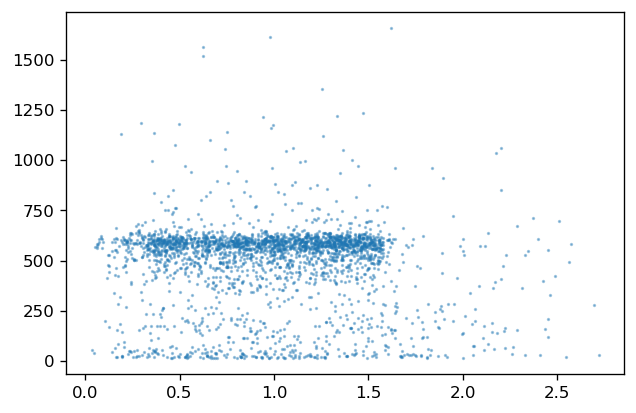

In [559]:
plt.scatter( min_angs['cluster_ang'], min_angs['cl_en'], alpha=0.4, s=1 );

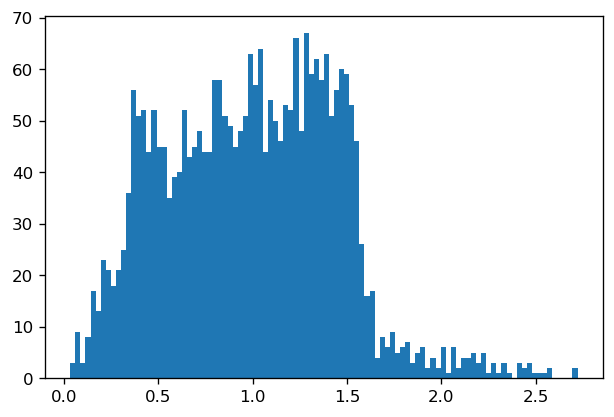

In [560]:
plt.hist( min_angs['cluster_ang'], bins=100 );

In [366]:
df2['mlt'].columns

Index(['ksalign', 'ksdpsi', 'kslen', 'ksminv', 'ksphi', 'ksptot', 'ksth',
       'ksz0', 'tdedx_n', 'tdedx_p', 'tphi_n', 'tphi_p', 'tptot_n', 'tptot_p',
       'trho_n', 'trho_p', 'tth_n', 'tth_p', 'tz_n', 'tz_p', 'ebeam', 'emeas',
       'lumoff', 'lumofferr', 'runnum', 'finalstate_id', 'badrun', 'x1', 'x2',
       'minv2p', 'cl_th', 'cl_ph', 'cl_en'],
      dtype='object')

In [ ]:
df2['mlt'].groupby('entry').agg()

In [364]:
df2['mlt']

ksalign    ksdpsi     kslen      ksminv     ksphi  \
entry  subentry                                                       
36     0         0.914762  1.425627  0.135810  450.869781  1.123244   
       1         0.914762  1.425627  0.135810  450.869781  1.123244   
       2         0.914762  1.425627  0.135810  450.869781  1.123244   
       3         0.914762  1.425627  0.135810  450.869781  1.123244   
       4         0.914762  1.425627  0.135810  450.869781  1.123244   
...                   ...       ...       ...         ...       ...   
154051 1         0.999735  2.184627  2.973134  484.907074  3.018963   
       2         0.999735  2.184627  2.973134  484.907074  3.018963   
       3         0.999735  2.184627  2.973134  484.907074  3.018963   
154138 0         0.989987  2.814113  0.228710  516.665833  2.649914   
       1         0.989987  2.814113  0.228710  516.665833  2.649914   

                     ksptot      ksth      ksz0      tdedx_n      tdedx_p  \
entry  subentry                                                             
36     0         454.427979  0.947078 -0.018749  2920.450439  2170.348145   
       1         454.427979  0.947078 -0.018749  2920.450439  2170.348145   
       2         454.427979  0.947078 -0.018749  2920.450439  2170.348145   
       3         454.427979  0.947078 -0.018749  2920.450439  2170.348145   
       4         454.427979  0.947078 -0.018749  2920.450439  2170.348145   
...                     ...       ...       ...          ...          ...   
154051 1         370.763367  2.503115  1.543969  2575.728516  2113.392090   
       2         370.763367  2.503115  1.543969  2575.728516  2113.392090   
       3         370.763367  2.503115  1.543969  2575.728516  2113.392090   
154138 0         329.518707  1.324718 -2.042770  2299.780518  4308.622559   
       1         329.518707  1.324718 -2.042770  2299.780518  4308.622559   

                 ...  lumofferr  runnum  finalstate_id  badrun         x1  \
entry  subentry  ...                                                        
36     0         ...        0.0   45573              3   False -81.425255   
       1         ...        0.0   45573              3   False -81.425255   
       2         ...        0.0   45573              3   False -81.425255   
       3         ...        0.0   45573              3   False -81.425255   
       4         ...        0.0   45573              3   False -81.425255   
...              ...        ...     ...            ...     ...        ...   
154051 1         ...        0.0   45573              2   False  -9.234806   
       2         ...        0.0   45573              2   False  -9.234806   
       3         ...        0.0   45573              2   False  -9.234806   
154138 0         ...        0.0   45573              3   False  39.203784   
       1         ...        0.0   45573              3   False  39.203784   

                        x2                                             minv2p  \
entry  subentry                                                                 
36     0         45.000801  [419.46137993893063, 401.21513738045434, 125.5...   
       1         45.000801  [419.46137993893063, 401.21513738045434, 125.5...   
       2         45.000801  [419.46137993893063, 401.21513738045434, 125.5...   
       3         45.000801  [419.46137993893063, 401.21513738045434, 125.5...   
       4         45.000801  [419.46137993893063, 401.21513738045434, 125.5...   
...                    ...                                                ...   
154051 1         -9.284036  [300.5371604551315, 144.01899151048448, 147.21...   
       2         -9.284036  [300.5371604551315, 144.01899151048448, 147.21...   
       3         -9.284036  [300.5371604551315, 144.01899151048448, 147.21...   
154138 0        -28.348237                               [233.89563415897481]   
       1        -28.348237                               [233.89563415897481]   

                    cl_th     cl_ph 

In [305]:
df2['mc'].columns

Index(['ksalign', 'ksdpsi', 'kslen', 'ksminv', 'ksptot', 'ksz0', 'tdedx_n',
       'tdedx_p', 'tphi_n', 'tphi_p', 'tptot_n', 'tptot_p', 'trho_n', 'trho_p',
       'tth_n', 'tth_p', 'tz_n', 'tz_p', 'ebeam', 'emeas', 'lumoff',
       'lumofferr', 'runnum', 'finalstate_id', 'badrun', 'x1', 'x2', 'minv2p',
       'ksth'],
      dtype='object')

In [313]:
# recoils = {}
for k in df2:
#     print(k)
    v0 = vector.obj(px=0, py=0, pz=0, E=625*2)
    v = vector.array(
        {
            'pt' : df2[k]['ksptot']*np.sin(df2[k]['ksth']),
            'theta' : df2[k]['ksth'],
            'phi' : np.zeros_like(df2[k]['ksminv']),
            'mass' : df2[k]['ksminv'],
        })
#     recoils[k] = (v0 - v).mass
    df2[k]['recoil'] = (v0 - v).mass

In [339]:
vector.obj(px=0, py=0, pz=5, E=4).mass

-3.0

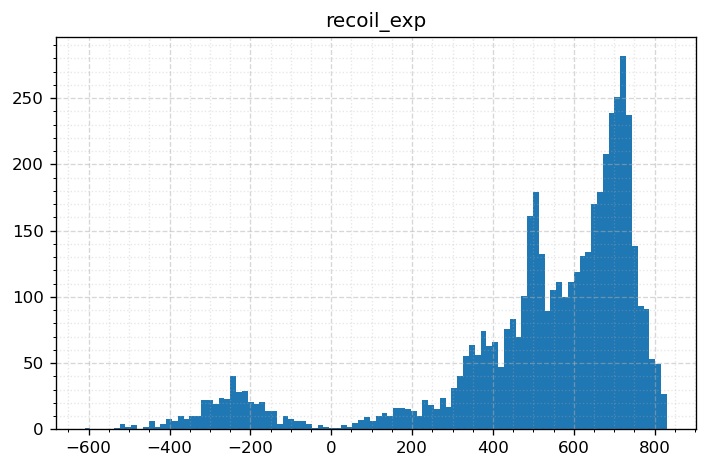

In [340]:
key='exp'
plt.hist( df2[key].recoil, bins=100);
pys.my_style(f'recoil_{key}')

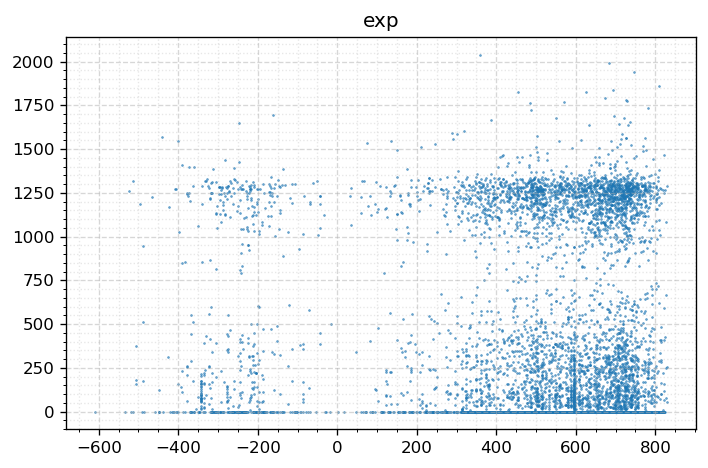

In [345]:
dtemp = df2['exp'].explode('minv2p')
plt.scatter(dtemp.recoil, dtemp.minv2p, marker='.', s=1, alpha=0.8);
pys.my_style('exp')

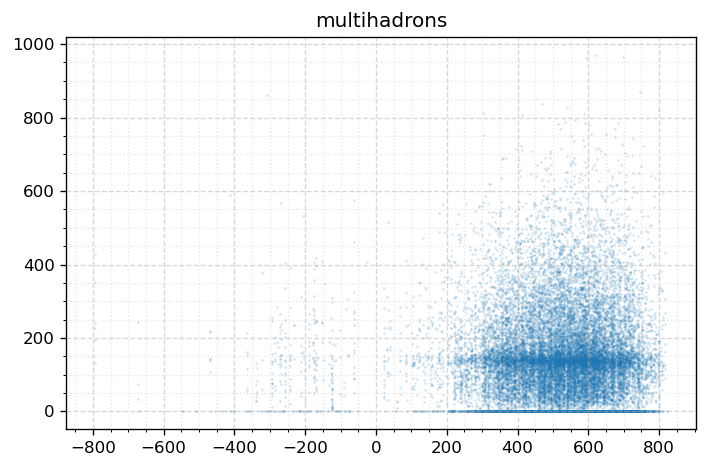

In [344]:
dtemp = df2['mlt'].explode('minv2p')
plt.scatter(dtemp.recoil, dtemp.minv2p, marker='.', s=1, alpha=0.2);
pys.my_style('multihadrons')

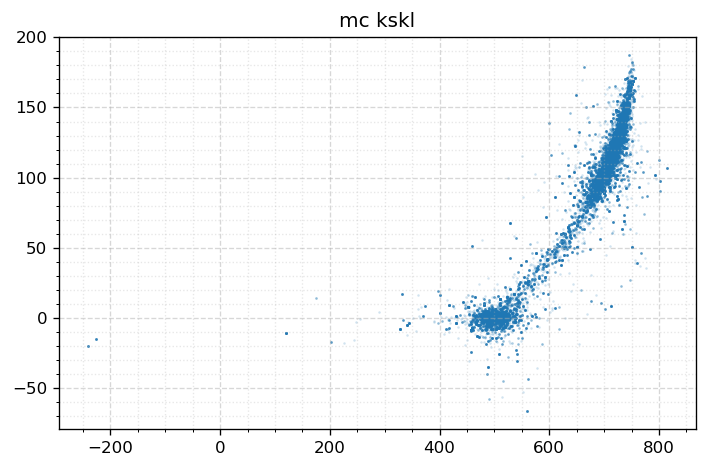

In [342]:
dtemp = df2['mc'].explode('minv2p')
plt.scatter(dtemp.recoil, dtemp.x1, marker='.', s=1, alpha=0.2);
pys.my_style('mc kskl')

In [336]:
# plt.hist(df2['mc'].minv2p, bins=100, range=(0, 2e3));
# plt.hist(df2['mlt'].minv2p, bins=100, range=(0, 2e3));
# plt.hist(df2['exp'].minv2p, bins=100, range=(0, 2e3));

In [51]:
photons.head(10)#apply(lambda x: vector.obj(pt=x['pt'], phi=x['phphi'], theta=x['phth'], mass=0).p, axis=1)

phen      phth     phphi          pt
entry subentry                                            
0     0         431.261078  1.695651  0.177161  427.904053
      1         401.017456  1.496694  3.096275  399.916931
      2          93.960617  0.504428  0.083609   45.411789
      3          79.175346  2.208287  1.854289   63.624683
      4          23.979954  1.555657  5.946864   23.977205
1     0         191.771729  1.200107  6.045491  178.746201
      1         112.026405  2.362574  3.836302   78.707642
      2          96.671768  1.877148  2.487082   92.170761
      3          62.128147  1.193837  4.585047   57.766010
2     0         248.350769  2.257845  4.089044  192.005234

In [46]:
photons.head()

phen      phth     phphi          pt
entry subentry                                            
0     0         431.261078  1.695651  0.177161  427.904053
      1         401.017456  1.496694  3.096275  399.916931
      2          93.960617  0.504428  0.083609   45.411789
      3          79.175346  2.208287  1.854289   63.624683
      4          23.979954  1.555657  5.946864   23.977205

In [33]:
1

1

In [6]:
%%time
dfs = {}
for t in tr:
    h = preprocess.Handler(tr[t])
    dfs[t] = h.get_good_kaons()

CPU times: user 15.9 s, sys: 2.15 s, total: 18.1 s
Wall time: 42.4 s


In [7]:
dfs.keys()

dict_keys(['exp', 'mc', 'mlt', 'kkp', 'kkpp'])

In [8]:
dfs['exp'].head()

ksalign    ksdpsi     kslen      ksminv      ksptot      ksz0  \
entry                                                                   
2251   0.999972  1.900876  2.558726  496.499573  394.050110 -3.049370   
2435   0.986876  2.880664  0.103706  569.400757  443.115173 -3.922080   
2585   0.837105  2.342966  0.032995  439.960663  166.777512 -1.099568   
2739   0.926781  1.944302  0.031215  496.484039  280.592010  2.025163   
3751   0.890133  3.108075  3.794865  455.733246   25.973003 -3.937625   

           tdedx_n      tdedx_p    tphi_n    tphi_p  ...      tz_p  ebeam  \
entry                                                ...                    
2251   3316.717041  2355.593750  3.930897  5.831915  ... -2.998950  800.0   
2435   2033.970825  4654.928223  0.191531  3.163248  ... -3.937364  800.0   
2585   2802.407715  2151.601807  5.427256  1.509877  ... -1.124240  800.0   
2739   2058.804688  2490.145752  0.626301  2.940413  ...  1.996369  800.0   
3751   2483.831787  2145.579834  5.217541  2.020152  ... -4.188921  800.0   

       emeas   lumoff  lumofferr  runnum  finalstate_id  badrun          x1  \
entry                                                                         
2251   797.5  5.05754   0.172964   15287              0   False   83.457008   
2435   797.5  5.05754   0.172964   15287              0   False  133.136734   
2585   797.5  5.05754   0.172964   15287              0   False  114.681282   
2739   797.5  5.05754   0.172964   15287              0   False  125.267532   
3751   797.5  5.05754   0.172964   15287              0   False  181.248947   

               x2  
entry              
2251  -213.433777  
2435  -140.950073  
2585  -445.542633  
2739  -318.907104  
3751  -570.616333  

[5 rows x 27 columns]

In [9]:
# df_ex.to_csv(f'../csv/11/{df_ex.iloc[0].ebeam:.2f}.csv')

In [10]:
def psi_angle_min(p_ks): #p_ks, MeV
    mpi = 139.6
    mks = 497.6
    V = p_ks/np.sqrt(p_ks**2 + mks**2)
    v0 = np.sqrt((mks/2)**2 - mpi**2)/(mks/2)
    pmin = np.where(V<v0, 2*np.arctan( (v0/V)*np.sqrt(1 - V**2) ), np.where(V<(v0/np.sqrt(1- v0**2)), 0, 0))
    return pmin

def get_lim_mom(p, sign=1):
    mk, mpi = 497.6, 139
    e = np.sqrt(p**2 + mk**2)
    v = p/e
    e0 = mk/2
    p0 = np.sqrt(e0**2 - mpi**2)
    e_res = (e0 + sign*v*p0)/np.sqrt(1 - v**2)
    return np.sqrt(e_res**2 - mpi**2)

def ctr(df, c=0, ptot_cut=40):
    df = df.query(f'(abs(trho_n)>{c})&(abs(trho_p)>{c})&(tptot_p>{ptot_cut})&(tptot_n>{ptot_cut})&(ksdpsi<3)')
#     df = df.query(f'((abs(trho_n)>{c})|(abs(trho_p)>{c}))&(tptot_p>{ptot_cut})&(tptot_n>{ptot_cut})&(ksdpsi<3)') #1 rho cut
#     df = df.loc[ (df.tptot_p - get_lim_mom(df.ksptot, 1) < 20) & (df.tptot_n - get_lim_mom(df.ksptot, 1) < 20) ]
#     df = df.loc[ (df.tptot_p - get_lim_mom(df.ksptot, -1) > -20) & (df.tptot_n - get_lim_mom(df.ksptot, -1) > -20) ]
#     df = df.loc[ np.abs(df['ksz0']) < 12 ]
    return df

In [11]:
# st = 'p'
# plt.scatter(ctr(dfs['exp'], 0.0)[f'tptot_{st}'], 
#             ctr(dfs['exp'], 0.0)[f'tdedx_{st}'], marker='.', s=1)
# pys.my_style()
# # plt.xlim(100, 400);

In [12]:
# joint = lambda df: sns.jointplot(data=ctr(df, 0.0), 
#               x='ksptot', y='ksminv', kind='hex', 
#               joint_kws=dict(gridsize=60)
#              )
# joint(ctr(dfs['mc'], 0.))
# joint(ctr(dfs['exp'], 0.))

In [13]:
def one_rho_cut(df, rho=0.1):
    return df.query(f'(abs(trho_p)>{rho})|(abs(trho_n)>{rho})')

In [14]:
dfs1= {}
dfs1['exp'] = one_rho_cut(dfs['exp'], 0.1)
dfs1['mc'] = one_rho_cut(dfs['mc'], 0.1)

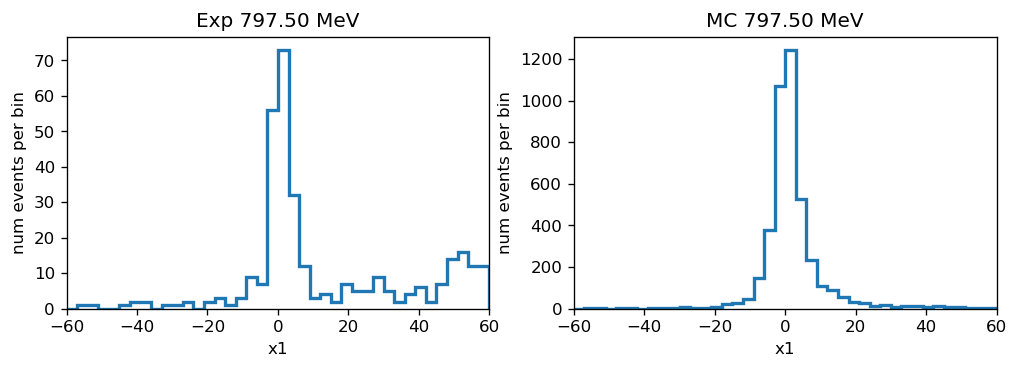

In [15]:
rng = (-60, 60)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.hist(dfs1['exp'].x1, bins=40, range=rng, histtype='step', lw=2);
ax1.set(title=f'Exp {dfs1["exp"].emeas.iloc[0]:.2f} MeV', xlabel='x1', ylabel='num events per bin', xlim=rng);
ax2.hist(dfs1['mc'].x1, bins=40, range=rng, histtype='step', lw=2);
ax2.set(title=f'MC {dfs1["mc"].emeas.iloc[0]:.2f} MeV', xlabel='x1', ylabel='num events per bin', xlim=rng);

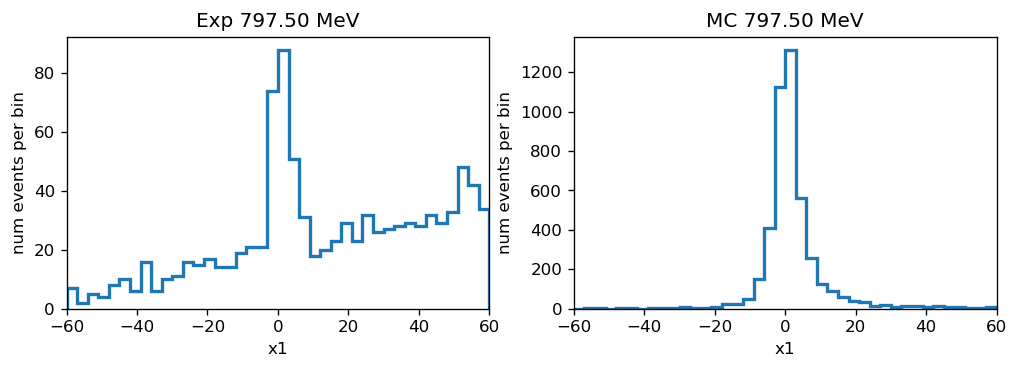

In [16]:
rng = (-60, 60)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.hist(ctr(dfs['exp'], 0.).x1, bins=40, range=rng, histtype='step', lw=2);
ax1.set(title=f'Exp {dfs["exp"].emeas.iloc[0]:.2f} MeV', xlabel='x1', ylabel='num events per bin', xlim=rng);
ax2.hist(ctr(dfs['mc'], 0.).x1, bins=40, range=rng, histtype='step', lw=2);
ax2.set(title=f'MC {dfs["mc"].emeas.iloc[0]:.2f} MeV', xlabel='x1', ylabel='num events per bin', xlim=rng);

Видно, что хотя пик и виден, но количество фона велико

In [17]:
import iminuit

In [21]:
r_cut = 0.
rng, bns = (-140, 250), 100
exp_hst, bins_hst = np.histogram(ctr(dfs['exp'], r_cut).x1, range=rng, bins=bns)
mlt_hst, _ = np.histogram(ctr(dfs['mlt'].query('finalstate_id!=8'), r_cut).x1, range=rng, bins=bns)
mc_hst, _ = np.histogram(ctr(dfs['mc'], r_cut).x1, range=rng, bins=bns)
kp_hst, _ = np.histogram(ctr(dfs['kkp'], r_cut).x1, range=rng, bins=bns)
kk_hst, _ = np.histogram(ctr(dfs['kkpp'], r_cut).x1, range=rng, bins=bns)

In [22]:
m0 = iminuit.Minuit(lambda a, b, c, d: np.sum(np.extract(exp_hst>0, (exp_hst - a*mlt_hst - b*mc_hst - c*kp_hst - d*kk_hst)**2/exp_hst)),
                    a=0.1, b=0.1, c=0.1, d=0.1)
m0.errordef = 1

In [23]:
m0.migrad()

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 250.2                      │              Nfcn = 78               │
│ EDM = 1.31e-21 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.500   │   0.024   │            │            │         │         │       │
│ 1 │ b    │   0.045   │   0.004   │            │            │         │         │       │
│ 2 │ c    │  0.0137   │  0.0021   │            │            │         │         │       │
│ 3 │ d    │   1.22    │   0.14    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         a         b         c         d │
├───┼─────────────────────────────────────────┤
│ a │  0.000577 -3.59e-05 -1.66e-05  -0.00161 │
│ b │ -3.59e-05  2.01e-05  1.64e-06  3.05e-06 │
│ c │ -1.66e-05  1.64e-06  4.45e-06 -0.000137 │
│ d │  -0.00161  3.05e-06 -0.000137    0.0205 │
└───┴─────────────────────────────────────────┘

In [24]:
m0.values

<ValueView a=0.4999563556399345 b=0.044642459669045995 c=0.013732144206068905 d=1.2169132659507287>

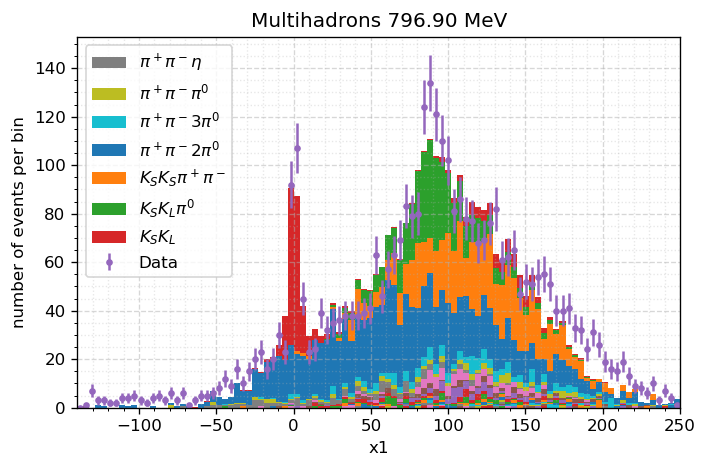

In [26]:
n_val = 30
final_states = ['$\pi^+\pi^-\pi^0$', '$2\pi^+2\pi^-$', '$\pi^+\pi^-2\pi^0$', '$2\pi^+2\pi^-\pi^0$', '$2\pi^+2\pi^-2\pi^0$', '$3\pi^+3\pi^-$',
               '$K^+K^-$', '$K_SK_L$', '$K^+K^-\pi^0$', '$K_SK^+\pi^-$', '$K_LK^-\pi^+$', '$K^+K^-\pi^+\pi^-$', '$K^+K^-\pi^0\pi^0$', '$K_LK_S\pi^+\pi^-$', 
               '$K^+K_S\pi^-\pi^0$', '$K^-K^0\pi^+\pi^0$', '$K_LK_S\pi^0\pi^0$', '$\pi^+\pi^-$', '$p\bar{p}$', '$n\bar{n}$', '$\pi^+\pi^-\eta$', 
               '$K_SK^-\pi^+$', '$K_LK^+\pi-$', '$\pi^+\pi^-3\pi^0$', '$\pi^+\pi^-4\pi^0$', '$K_SK_S\pi^+\pi^-$', '$\pi^0\gamma$', '$\eta\gamma$', 
               'wtf', '$K_SK_L\pi^0$', '$K_SK_S\pi^+\pi^-$']
plt.figure()
processes = list(dfs['mlt'].query('finalstate_id!=8').finalstate_id.value_counts().sort_values(ascending=True).index)
dat, ws = [], []
for process in processes:
    dat.append( ctr(dfs['mlt'].query(f'finalstate_id=={process}'), r_cut).x1 )
#     ws.append( np.ones_like(dat[-1])*len(df_ex.query(f'abs(x1)<{n_val}'))/len(d_temp.query(f'abs(x1)<{n_val}')) )
    ws.append(np.ones_like(dat[-1])*m0.values['a'])

processes.append(31)
dat.append(ctr(dfs['kkpp'], r_cut).x1)
ws.append(np.ones_like(dat[-1])*m0.values['d'])
# ws.append(np.ones_like(dat[-1])*(2/5))    
    
processes.append(30)
dat.append(ctr(dfs['kkp'], r_cut).x1)
ws.append(np.ones_like(dat[-1])*m0.values['c'])
# ws.append(np.ones_like(dat[-1])/100)
# ws.append(np.ones_like(dat[-1])*
#           (len(df_ex.query(f'abs(x1)<{n_val}'))*(1 - len(d_temp.query(f'(finalstate_id!=8)&(abs(x1)<{n_val})'))/len(d_temp.query(f'(abs(x1)<{n_val})'))))/
#           len(df_mc.query(f'abs(x1)<{n_val}'))*2.2/5)
    
processes.append(8)
processes = np.array(processes)
dat.append(ctr(dfs['mc'], r_cut).x1)
ws.append(np.ones_like(dat[-1])*m0.values['b'])
# ws.append(np.ones_like(dat[-1])*
#           (len(df_ex.query(f'abs(x1)<{n_val}'))*(1 - len(d_temp.query(f'(finalstate_id!=8)&(abs(x1)<{n_val})'))/len(d_temp.query(f'(abs(x1)<{n_val})'))))/
#           len(df_mc.query(f'abs(x1)<{n_val}')))

labs = np.array(final_states)[processes-1]
labs[:-7] = '_nolegend_'
plt.hist(dat, bins=bns, range=rng, stacked=True, label=labs, alpha=1, histtype='bar', lw=2,
        weights=ws)
pys.hep_histo(ctr(dfs['exp'], r_cut).x1, bins=bns, range=rng, label='Data', roll_bins=0)
pys.my_style(title=f'Multihadrons {dfs["mlt"].iloc[0].emeas:.2f} MeV', xtitle='x1', ytitle='number of events per bin', xlim=rng, legend=True, ylim=(0, None));

Как определить сечение доп. процессов $ K_S K_L \pi^0$ или $K_S K_S \pi^+ \pi^-$ (нужны видимые сечения, не борновские)

In [ ]:
plt.errorbar((bins_hst[1:] + bins_hst[:-1])/2, 
             exp_hst - m0.values['a']*mlt_hst - m0.values['b']*mc_hst - m0.values['c']*kp_hst - m0.values['d']*kk_hst, yerr=np.sqrt(exp_hst), fmt='.')
pys.my_style(title='Residual plot', xtitle='x1', ytitle='difference')

In [ ]:
bkg_rng, bkg_bns = (-140, 250), 100
bkg_hst, bkg_bins = np.histogram(dat[0], bkg_bns, bkg_rng)
bkg_hst = bkg_hst.astype(float)
bkg_err = np.sqrt(bkg_hst)
scale = ws[0][0] if len(ws[0])>0 else 0.
bkg_hst, bkg_err = bkg_hst*scale, bkg_err*scale 
for i, d in enumerate(dat[1:-1]):
    temp_hst, _ = np.histogram(d, bkg_bns, bkg_rng)
    scale = ws[i+1][0] if len(ws[i+1])>0 else 0.
    bkg_hst = bkg_hst + temp_hst*scale
    bkg_err = bkg_err + np.sqrt(temp_hst)*scale

In [ ]:
center_bins = (bkg_bins[1:]+bkg_bins[:-1])/2
x_bkg, y_bkg, yerr_bkg = center_bins[np.abs(center_bins)<50], bkg_hst[np.abs(center_bins)<50], bkg_err[np.abs(center_bins)<50]
cost = iminuit.cost.LeastSquares(x_bkg, y_bkg, yerr_bkg, lambda x, k, b: k*x+b)
mbkg = iminuit.Minuit(cost, k=1, b=1)

In [ ]:
mbkg.migrad()

In [ ]:
plt.errorbar(center_bins, bkg_hst, yerr=bkg_err, fmt='.')
plt.plot(x_bkg, cost.model(x_bkg, *mbkg.values), zorder=3, lw=2)
pys.my_style(title='Bkg distribution', xtitle='x1')

In [60]:
rho_cut = 0.1
exp_df = ctr(dfs['exp'].query('abs(x1)<100'), rho_cut).x1
mc_df = ctr(dfs['mc'].query('abs(x1)<100'), rho_cut).x1

In [61]:
fit_range = (-50, 50)
hist_range = (-60, 60)
width = fit_range[1] - fit_range[0]

pars = {
    'n_sig' : 2000,
    'm' : 0,
    'sL' : 2,
    'sR' : 5,
    'aL' : 0,
    'aR' : 0,
    'y0' : 0.1,
    'dy' : 0.1,
    'x0' : -45,
}

lims = {
    'n_sig' : (0, None),
    'm' : (-10, 10),
    'sL' : (1, None),
    'sR' : (1, None),
    'aL' : (0, None),
    'aR' : (0, None),
    'y0' : (0, 0),
    'dy' : (0, 0),
    'x0' : (-40, -40),
}

In [62]:
f1 = pyfit.Fit1(fit_range)

In [63]:
dataE, dataM = exp_df.values, mc_df.values

f_mc = pyfit.Fitter(dataM, f1, pars, lims, fit_range)
f_mc.fit()

pars_mc = f_mc.get_params()
lims_mc = f_mc.get_limits(5, ['sL', 'sR', 'aL', 'aR'], 
                          {'y0': (0, None), 'dy': (0, None), 'x0': (None, fit_range[0]), })
sigm_mc = f_mc.get_sigmas(exclude=['n_sig', 'm', 'y0', 'dy', 'x0'])

f_exp = pyfit.Fitter(dataE, f1, pars_mc, lims_mc, fit_range, sigm_mc)
f_exp.fit()

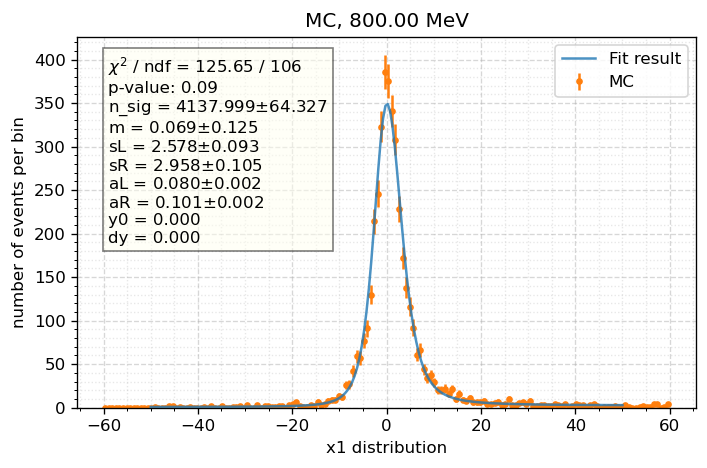

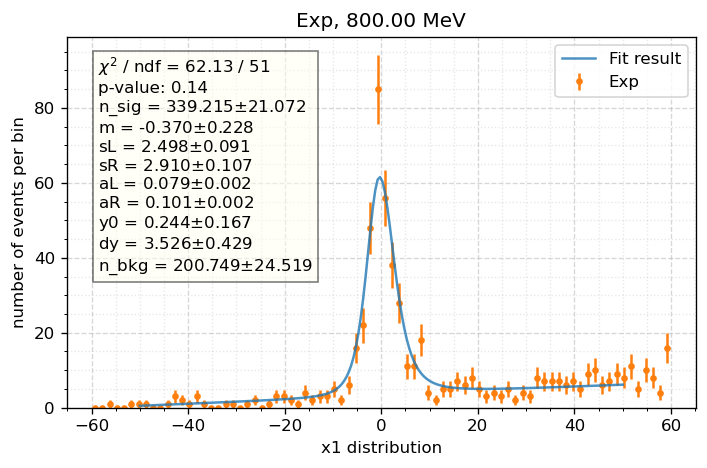

In [65]:
e0 = 800
f_mc.plot(hist_range, 160, f'MC, {e0:.2f} MeV', 'MC', 'x1 distribution', 
       'number of events per bin', fill_errors=False)
f_exp.plot(hist_range, 80, f'Exp, {e0:.2f} MeV', 'Exp', 'x1 distribution', 
       'number of events per bin', fill_errors=False)

попробовать кат на один трек, а не на оба: попробовал, смотреть 19/800

**19 год, 550 МэВ**

без ката на $\rho$: $N_{sig}/N_{bkg} = \frac{2197}{1484} = 1.48 $, stat_err = 2.9%

с катом на $\rho$: $N_{sig}/N_{bkg} = \frac{1802}{0\pm7} $, stat_err = 2.4%, sys_err_rho = 2.8%


**12 год, 800 МэВ**

без ката на $\rho$: $N_{sig}/N_{bkg} = \frac{205.5\pm19.3}{604.5\pm49.2} $, stat_err = 9.4%

с катом на $\rho$: $N_{sig}/N_{bkg} = \frac{168.4\pm13.9}{24.6\pm7.3} $, stat_err = 8.3%, sys_err_rho = 4.3%

**19 год, 800 МэВ**

без ката на $\rho$: $N_{sig}/N_{bkg} = \frac{377.5\pm25.5}{904.5\pm56.6} $, stat_err = 6.8%

кат на один $\rho$: $N_{sig}/N_{bkg} = \frac{339\pm21}{201\pm25} $, stat_err = 6.2%, sys_err_rho = 1.5%

с катом на $\rho$: $N_{sig}/N_{bkg} = \frac{309.5\pm18.9}{47.6\pm9.9} $, stat_err = 6.1%, sys_err_rho = 2.8%
____

11 год странный, нужно изучать 

Если дальше с фоном, то как быть с эффективностью триггеров, эффективностью ДК? смотреть под пиком

Multihadrons `800_10364` `root://cmd//sim/run053227.root`

KSKL MC `/store17/petrov/data/kskl20/raw/11/kskl_800_10364.root`

посмотреть от чего возникает фон справа: возможно космика, отрезал `ksdpsi > 3`

Отрезать фон + по максимальному углу

In [94]:
# # plt.scatter(data=ctr(df_mc, 0), x='ksptot', y='ksdpsi', s=1, alpha=1, label='exp')
# df = df_mc
# plt.scatter(data=df.loc[df.ksdpsi - psi_angle_min(df.ksptot) > 0], x='ksptot', y='ksdpsi', s=1, alpha=1, label='exp')
# plt.scatter(data=df.loc[df.ksdpsi - psi_angle_min(df.ksptot) < 0], x='ksptot', y='ksdpsi', s=1, alpha=1, label='exp')
# plt.plot(ptot, minpsi, color='black', label='strict geometric $\psi$ cut', alpha=0.85)

# pys.my_style(xtitle='x1', ytitle='$\psi$', legend=True);

In [273]:
def get_lim_mom(p, sign=1):
    mk, mpi = 497.6, 139
    e = np.sqrt(p**2 + mk**2)
    v = p/e
    e0 = mk/2
    p0 = np.sqrt(e0**2 - mpi**2)
    e_res = (e0 + sign*v*p0)/np.sqrt(1 - v**2)
    return np.sqrt(e_res**2 - mpi**2)
x0 = np.linspace(0, df_ex.ksptot.quantile(0.99), 200)
y0, y1 = get_lim_mom(x0, 1), get_lim_mom(x0, -1)

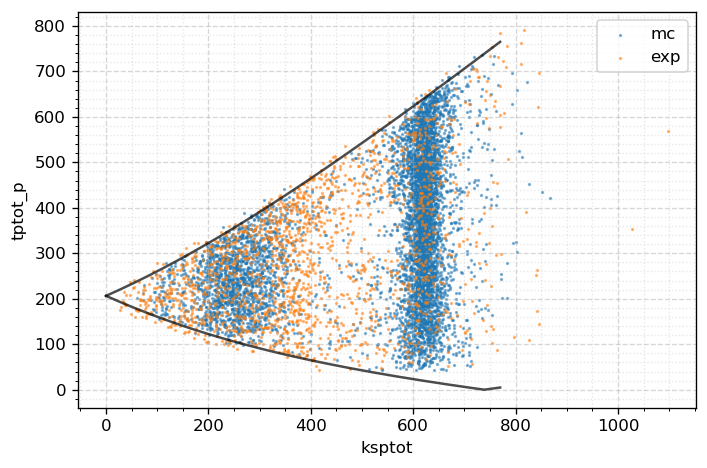

In [274]:
plt.scatter(data=ctr(df_mc, 0), x='ksptot', y='tptot_n', s=1, alpha=0.5, label='mc')
plt.scatter(data=ctr(df_ex, 0), x='ksptot', y='tptot_n', s=1, alpha=0.5, label='exp')
plt.plot(x0, y1, x0, y0, color='black', alpha=0.7)
pys.my_style(xtitle='ksptot', ytitle='tptot_p', legend=True);

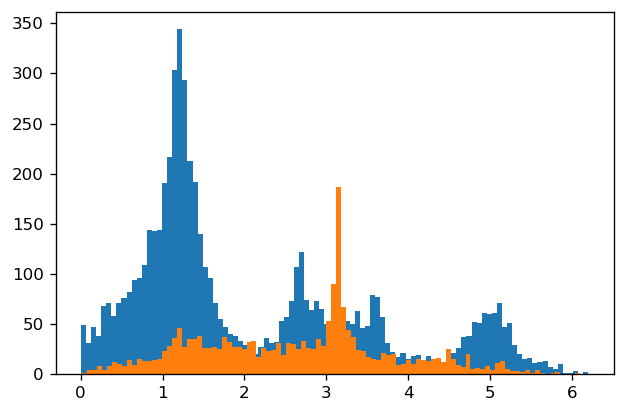

In [356]:
plt.hist(np.abs(df_mc['tphi_n'] - df_mc['tphi_p']), bins=100);
plt.hist(np.abs(df_ex['tphi_n'] - df_ex['tphi_p']), bins=100);

In [357]:
df_mc.columns

Index(['ksalign', 'ksdpsi', 'kslen', 'ksminv', 'ksptot', 'ksz0', 'tdedx_n',
       'tdedx_p', 'tphi_n', 'tphi_p', 'tptot_n', 'tptot_p', 'trho_n', 'trho_p',
       'tth_n', 'tth_p', 'tz_n', 'tz_p', 'ebeam', 'emeas', 'lumoff',
       'lumofferr', 'runnum', 'finalstate_id', 'badrun', 'x1', 'x2'],
      dtype='object')

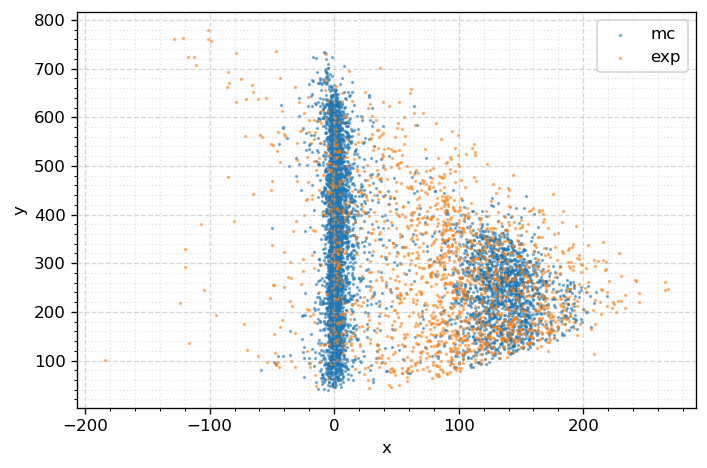

In [29]:
trs = lambda df: ( df['x1'], df['tptot_p'])
plt.scatter(*trs(ctr(dfs['mc'], 0)), s=1, alpha=0.5, label='mc')
plt.scatter(*trs(ctr(dfs['exp'], 0)), s=1, alpha=0.5, label='exp')
# plt.plot(x0, y1, x0, y0, color='black', alpha=0.7)
pys.my_style(xtitle='x', ytitle='y', legend=True);

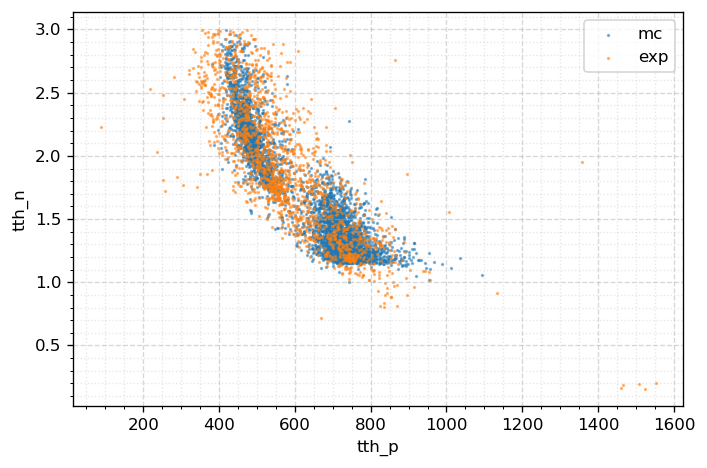

In [314]:
col = lambda df: (df['tptot_n']+ df['tptot_p'], df['ksdpsi'])
dmc = col(ctr(df_mc, 0))
dex = col(ctr(df_ex, 0))
plt.scatter(dmc[0], dmc[1], s=1, alpha=0.5, label='mc')
plt.scatter(dex[0], dex[1], s=1, alpha=0.5, label='exp')
# plt.plot(x0, y1, x0, y0, color='black', alpha=0.7)
pys.my_style(xtitle='tth_p', ytitle='tth_n', legend=True);

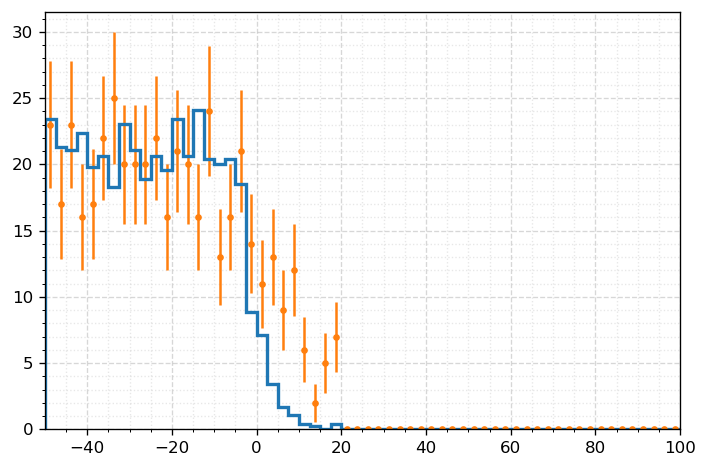

In [364]:
rng = (-50, 100)
dmc = -(ctr(df_mc, 0).tptot_n - get_lim_mom(ctr(df_mc, 0).ksptot, -1))
dex = -(ctr(df_ex, 0).tptot_n - get_lim_mom(ctr(df_ex, 0).ksptot, -1))
plt.hist(dmc, bins=60, label='mc', range=rng, 
         histtype='step', lw=2, weights=np.ones_like(dmc)*((dex>-40)&(dex<-20)).sum()/((dmc>-40)&(dmc<-20)).sum());
pys.hep_histo(dex, bins=60, label='exp', range=rng);
pys.my_style(xlim = rng)

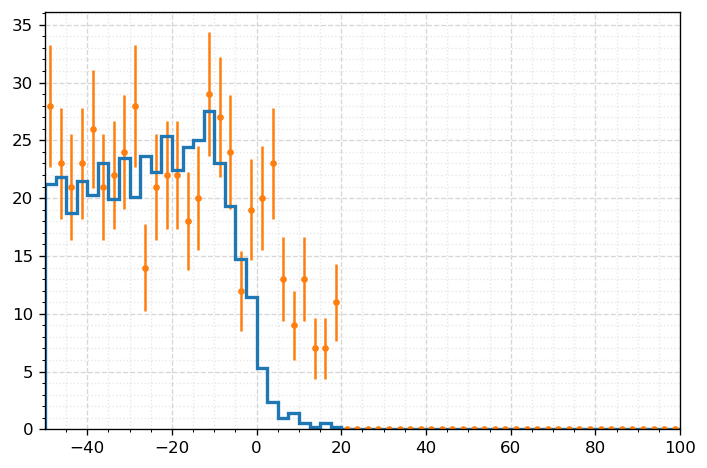

In [365]:
rng = (-50, 100)
dmc = ctr(df_mc, 0).tptot_p - get_lim_mom(ctr(df_mc, 0).ksptot, 1)
dex = ctr(df_ex, 0).tptot_p - get_lim_mom(ctr(df_ex, 0).ksptot, 1)
plt.hist(dmc, bins=60, label='mc', range=rng, 
         histtype='step', lw=2, weights=np.ones_like(dmc)*((dex>-40)&(dex<-20)).sum()/((dmc>-40)&(dmc<-20)).sum());
pys.hep_histo(dex, bins=60, label='exp', range=rng);
pys.my_style(xlim = rng)

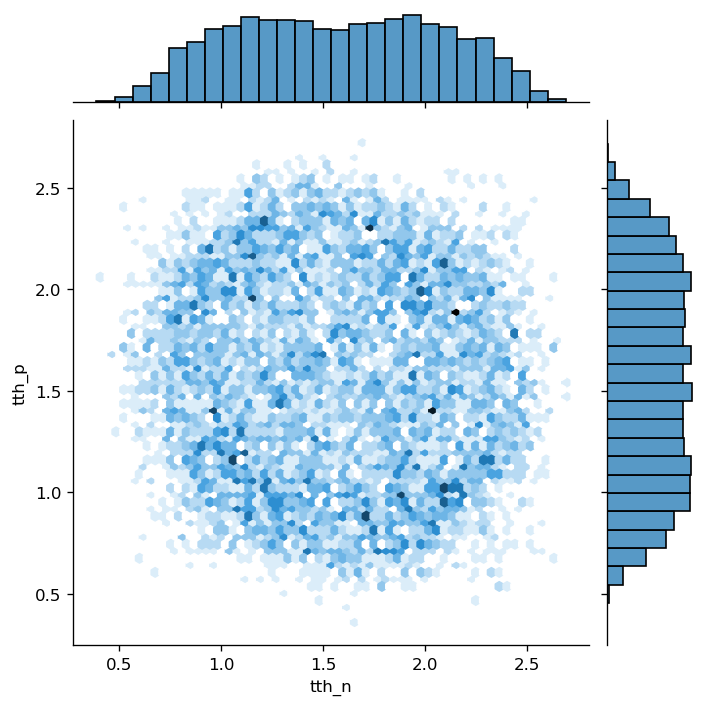

In [136]:
sns.jointplot(data=ctr(df_mc, 0.0), x='tth_n', y='tth_p', kind='hex', 
              joint_kws=dict(gridsize=60)
             )

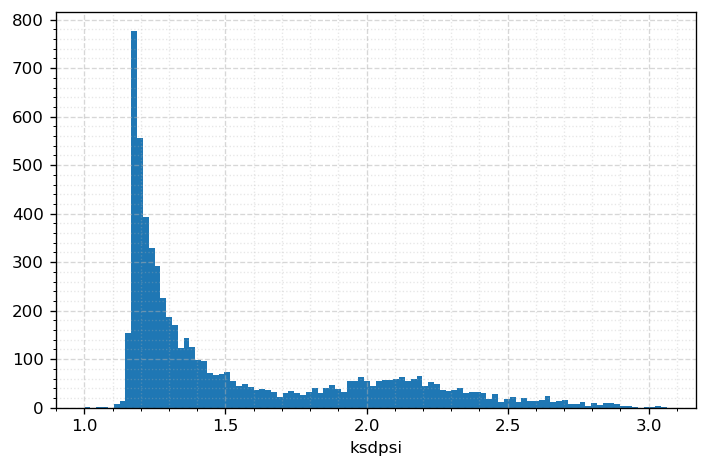

In [137]:
plt.hist(df_mc.ksdpsi, bins=100);
pys.my_style(xtitle='ksdpsi', title='')

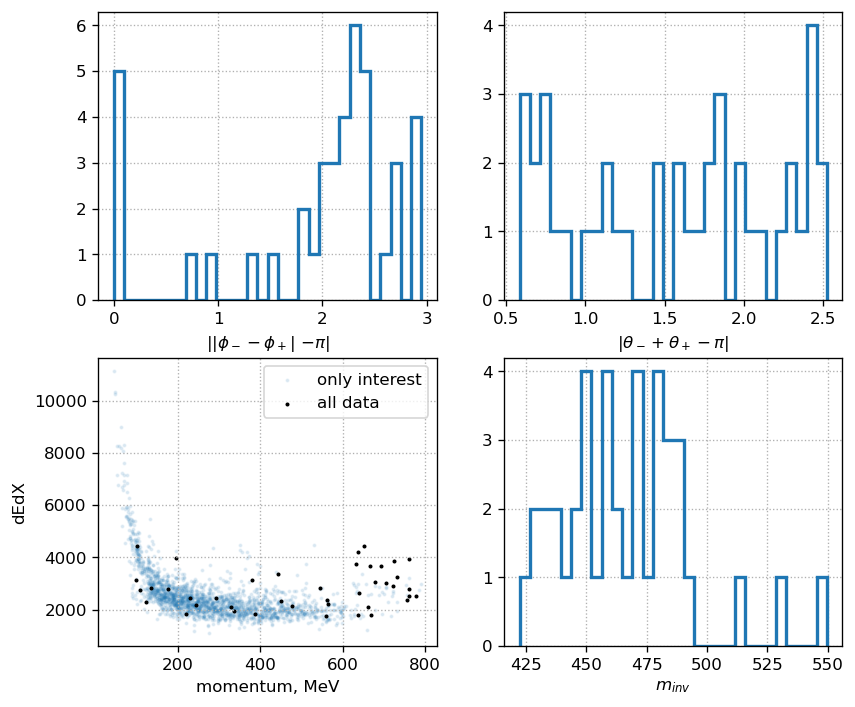

In [35]:
dt = dfs['exp'].loc[dfs['exp'].x1<-50]

fig, ax = plt.subplots(2, 2, figsize=(8, 7))
ax = ax.ravel()
labels = [['||$\phi_- - \phi_+$| $ - \pi$|']]
y0 = np.abs(np.abs(dt['tphi_n'] - dt['tphi_p']) - np.pi)
ax[0].hist(y0, bins=30, histtype='step', lw=2);

labels.append([r'|$\theta_- + \theta_+ - \pi$|'])
y1 = np.abs(dt['tth_n'])
ax[1].hist(y1, bins=30, histtype='step', lw=2);

ax[2].scatter(dfs['exp']['tptot_n'], dfs['exp']['tdedx_n'], s=2, label='only interest', alpha=0.1)
ax[2].scatter(dt['tptot_p'], dt['tdedx_p'], s=2, label='all data', color='black')
ax[2].legend()
labels.append(['momentum, MeV', 'dEdX'])


labels.append([r'$m_{inv}$'])
y1 = np.abs(dt['ksminv'])
ax[3].hist(y1, bins=30, histtype='step', lw=2);

for a, lab in zip(ax, labels):
    a.grid(ls=':')
    a.set(xlabel=lab[0], ylabel=lab[1] if len(lab)>1 else None)

Вершина от угла между треками и посмотреть

Понятно, что фон усложняет жизнь без отбора по $\rho$

вычесть $4\pi$ по сечению

взял 550 МэВ, 100к

сразу фит

In [84]:
df_mlt = df_mlt.dropna()

In [145]:
fit_range = (-50, 50)
hist_range = (-60, 60)
width = fit_range[1] - fit_range[0]

pars = {
    'y0' : 0.5,
    'y1' : 0.5,
}

lims = {
    'y0' : (0, None),
    'y1' : (0, None),
}

class FitLinear():
    def __init__(self, fit_range):
        self.fit_range = fit_range
        self.w = fit_range[1] - fit_range[0]
    def __call__(self, x, y0, y1):
        xmin, xmax = self.fit_range
        return ((y0+y1/2)*self.w, y0 + y1*(x - xmin)/(xmax - xmin))
    def get_nsig(self, minuit):
        return (0, 0)
    def get_nbkg(self, minuit):
        v = self.w*(minuit.values['y0']+minuit.values['y1']/2)
        e = self.w*np.sqrt(minuit.errors['y0']**2 + minuit.errors['y1']**2/2)
        return (v, e)

In [146]:
f1 = FitLinear(fit_range)
e0 = df_mlt.emeas.mean()

In [147]:
xmin, xmax = fit_range
f_lin = lambda x, y0, y1 : ( (y0 + y1/2)*(xmax-xmin), y0 + y1*(x - xmin)/(xmax - xmin))

In [148]:
cost = iminuit.cost.ExtendedUnbinnedNLL(datamlt[(datamlt>fit_range[0])&(datamlt<fit_range[1])], f_lin)

In [149]:
m = iminuit.Minuit(cost, y0=0.1, y1=0.2)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -7380                      │              Nfcn = 138              │
│ EDM = 5.19e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ y0   │   28.7    │    0.9    │            │            │         │         │       │
│ 1 │ y1   │   -20.1   │    1.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────┐
│    │    y0    y1 │
├────┼─────────────┤
│ y0 │ 0.883  -1.2 │
│ y1 │  -1.2  2.02 │
└────┴─────────────┘

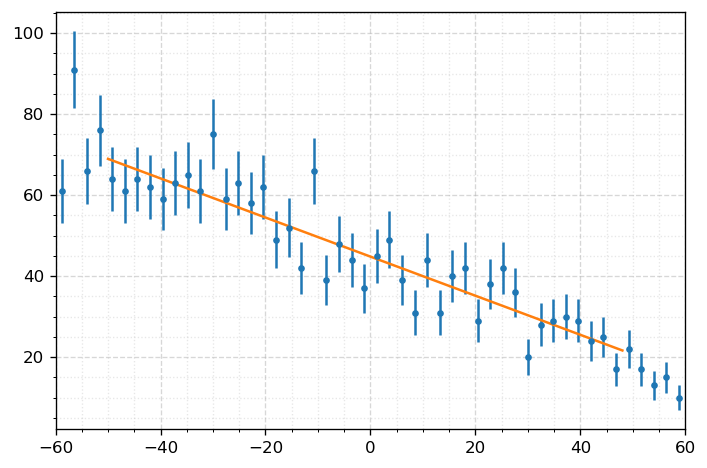

In [150]:
bins = 50
xx = np.arange(fit_range[0], fit_range[1], 2)
pys.hep_histo(datamlt, bins=bins, range=hist_range)
plt.plot(xx, cost.scaled_pdf(xx, *m.values)[1]*(hist_range[1] - hist_range[0])/bins)
pys.my_style(xlim=hist_range)

In [357]:
# df_4p = ak.to_pandas(tr_mlt.arrays(['trho', 'tth', 'tdedx', 'tptot'], 
#                            f'(nt==2)&(tth>0.8)&(tth<{np.pi-0.8})&(tnhit>12)&(abs(trho)<0.2)&(abs(pidedx)<2000)&(tchi2r<25)&(tchi2z<25)',
#                            aliases={'pidedx': '5.58030e+9 / (tptot + 40.)**3 + 2.21228e+3 - 3.77103e-1 * tptot - tdedx'}))
# d0 = ak.to_pandas(tr_mlt.arrays(['finalstate_id', 'emeas', 'ebeam']))
# d1 = ak.to_pandas(tr_mlt.arrays(['phen'], '(nt==2)')).groupby('entry').agg(en=('phen', 'sum'))
# d1 = d1.loc[d1.en<40]
# d1 = d1.append(ak.to_pandas(tr_mlt.arrays(['nph'], '(nt==2)&(nph==0)')).rename({'nph': 'en'}, axis=1))
# df_4p = df_4p.reset_index().set_index('entry').loc[df_4p.groupby('entry').agg(num=('trho', 'count')).num==2]\
#                 .join(d0, how='inner').join(d1, how='inner')

Fitting

In [93]:
SEASON = '11'
MC = 'v7'
N_MC = 20000

In [94]:
exp_path_pattern = lambda SEASON, file: f'../csv/{SEASON}/{file}'
mc_path_pattern = lambda SEASON, MC, file: f'../csv/mc/{MC}/{SEASON}/{file}'

In [95]:
exps = os.listdir(exp_path_pattern(SEASON, ''))
mcs = os.listdir(mc_path_pattern(SEASON, MC, ''))
files = sorted(list(set(mcs) & set(exps)))

In [96]:
file = files[0]

In [97]:
exp_file = exp_path_pattern(SEASON, file)
mc_file = mc_path_pattern(SEASON, MC, file)

In [98]:
exp_df = pd.read_csv(exp_file, index_col='entry')
mc_df = pd.read_csv(mc_file, index_col='entry')

In [99]:
def mom_constraints(ebeam, res=0.1):
    mk, mpi = 497.6, 139.6 #MeV
    V = np.sqrt( 1 - (mk/ebeam)**2)
    E0 = mk/2
    p0 = np.sqrt(E0**2 - mpi**2)
    pmin, pmax = (E0 - V*P0)/np.sqrt(1 - V**2), (E0 + V*P0)/np.sqrt(1 - V**2)
    return (pmin*(1-res), pmax*(1+res))

def mom_cut(df, res=0.1):
    cut1 = (df['tptot_p'] > mom_constraints(df.emeas, res)[0]) & (df['tptot_p'] < mom_constraints(df.emeas, res)[1])
    cut2 = (df['tptot_n'] > mom_constraints(df.emeas, res)[0]) & (df['tptot_n'] < mom_constraints(df.emeas, res)[1])
#     cut3 = (df['tptot_p'] + df['tptot_n']) < 550
    return df.loc[cut1 & cut2]

In [100]:
# exp_df = mom_cut(exp_df)
# mc_df = mom_cut(mc_df)

In [101]:
exp_df.head()

kalign     ksminv     ksptot    tdedx_n    tdedx_p     tptot_n  \
entry                                                                     
1796   0.835022  494.81860  434.11176  3258.2893  2579.7693  176.555820   
3494   0.997347  494.36475  126.51439  3347.3801  2486.4450  155.663880   
4343   0.988489  541.52030  429.01236  2348.3962  3206.8710  251.138320   
6611   0.821608  485.49710  344.34122  2528.2986  3272.0974  357.730870   
11900  0.997950  537.80710  333.87720  3766.3184  3710.3100  106.093376   

         tptot_p    trho_n    trho_p      tz_n  ...   emeas   lumoff  \
entry                                           ...                    
1796   407.96988 -0.018087 -0.039569  0.487827  ...  548.44  7.81239   
3494   265.32460  0.269219 -0.168770 -3.087238  ...  548.44  7.81239   
4343   437.45712  0.019144  0.067233 -2.670847  ...  548.44  7.81239   
6611   159.39233  0.002215  0.013758 -4.183397  ...  548.44  7.81239   
11900  442.63757 -0.021377 -0.059301  1.278828  ...  548.44  7.81239   

       lumofferr  runnum  finalstate_id  badrun         x1         x2  \
entry                                                                   
1796    0.161432    9158              0   False -133.50827  153.61154   
3494    0.161432    9158              0   False   64.73462  -81.58219   
4343    0.161432    9158              0   False  -94.55164  179.86867   
6611    0.161432    9158              0   False  -82.66955   79.03900   
11900   0.161432    9158              0   False  -35.96659  104.82016   

       tptot_mean  tdedx_mean  
entry                          
1796    292.26285   2919.0293  
3494    210.49423   2916.9126  
4343    344.29773   2777.6338  
6611    258.56158   2900.1980  
11900   274.36548   3738.3142  

[5 rows x 22 columns]

In [102]:
exp_df.columns

Index(['kalign', 'ksminv', 'ksptot', 'tdedx_n', 'tdedx_p', 'tptot_n',
       'tptot_p', 'trho_n', 'trho_p', 'tz_n', 'tz_p', 'ebeam', 'emeas',
       'lumoff', 'lumofferr', 'runnum', 'finalstate_id', 'badrun', 'x1', 'x2',
       'tptot_mean', 'tdedx_mean'],
      dtype='object')

In [103]:
exp_df['tptot_sum'] = exp_df['tptot_p'] + exp_df['tptot_n']
mc_df['tptot_sum'] = mc_df['tptot_p'] + mc_df['tptot_n']

In [104]:
exp_df['tdedx_sum'] = exp_df['tdedx_p'] + exp_df['tdedx_n']
mc_df['tdedx_sum'] = mc_df['tdedx_p'] + mc_df['tdedx_n']

In [105]:
exp_df['trho_sum'] = exp_df['trho_p'] + exp_df['trho_n']
mc_df['trho_sum'] = mc_df['trho_p'] + mc_df['trho_n']

In [106]:
exp_df['tz_sum'] = exp_df['tz_p'] + exp_df['tz_n']
mc_df['tz_sum'] = mc_df['tz_p'] + mc_df['tz_n']

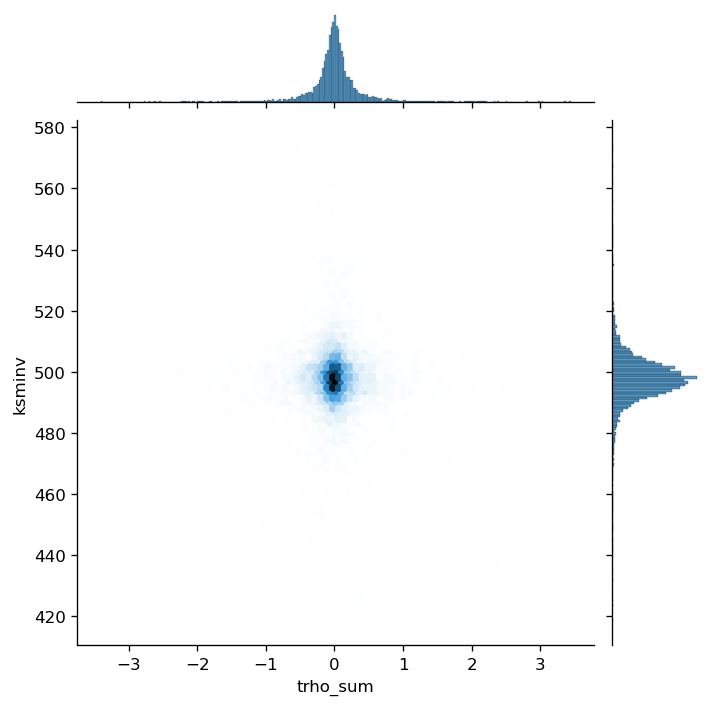

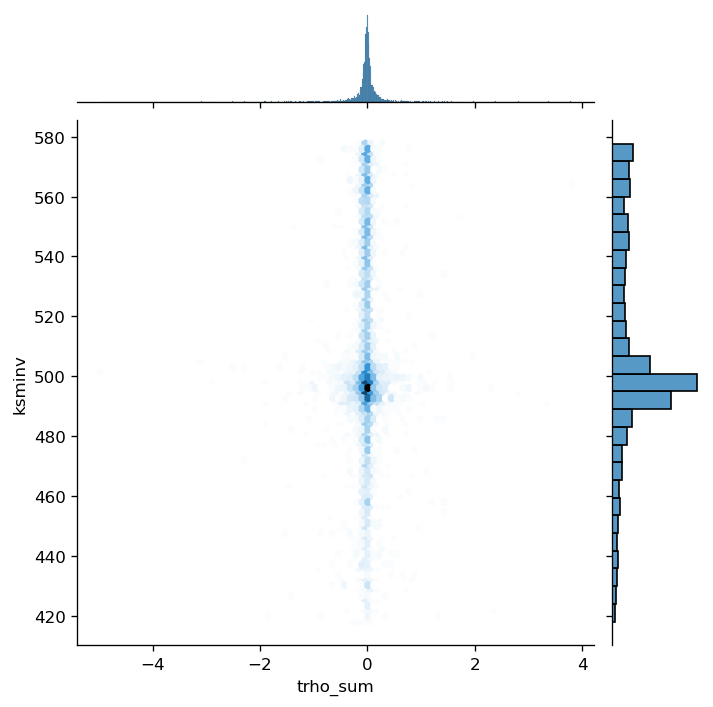

In [107]:
joint = lambda df: sns.jointplot(data=df, 
              x='trho_sum', y='ksminv', kind='hex',
              joint_kws=dict(gridsize=80))
joint(mc_df)
joint(exp_df)

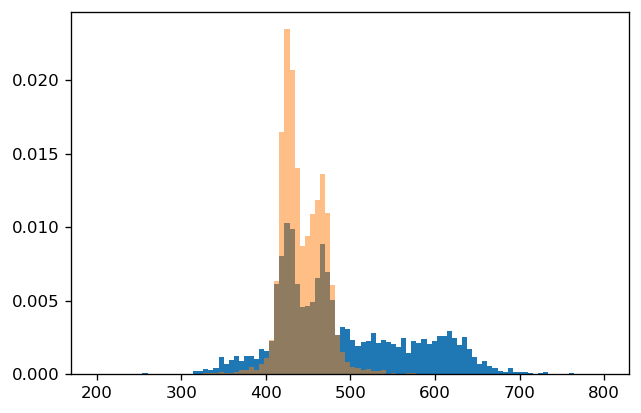

In [108]:
rng = (200, 800)
col = 'tptot_sum'
plt.hist(exp_df[col], density=True, bins=100, range=rng);
plt.hist(mc_df[col], density=True, bins=100, range=rng, alpha=0.5);

In [109]:
fit_range = (-40, 40)
hist_range = (-60, 60)
width = fit_range[1] - fit_range[0]

pars = {
    'n_sig' : 2000,
    'm' : 0,
    'sL' : 2,
    'sR' : 5,
    'aL' : 0,
    'aR' : 0,
    'y0' : 0.1,
    'dy' : 0.1,
    'x0' : -45,
}

lims = {
    'n_sig' : (0, None),
    'm' : (-10, 10),
    'sL' : (1, None),
    'sR' : (1, None),
    'aL' : (0, None),
    'aR' : (0, None),
    'y0' : (0, 0),
    'dy' : (0, 0),
    'x0' : (-40, -40),
}

In [110]:
f1 = pyfit.Fit1(fit_range)

In [111]:
e0 = exp_df.emeas.mean()

In [123]:
dataE, dataM = exp_df.x1.values, mc_df.x1.values

f_mc = pyfit.Fitter(dataM, f1, pars, lims, fit_range)
f_mc.fit()

pars_mc = f_mc.get_params()
lims_mc = f_mc.get_limits(5, ['sL', 'sR', 'aL', 'aR'], 
                          {'y0': (0, None), 'dy': (-4.35, None), 'x0': (None, fit_range[0]), })
sigm_mc = f_mc.get_sigmas(exclude=['n_sig', 'm', 'y0', 'dy', 'x0'])

f_exp = pyfit.Fitter(dataE, f1, pars_mc, lims_mc, fit_range, sigm_mc)
f_exp.fit()

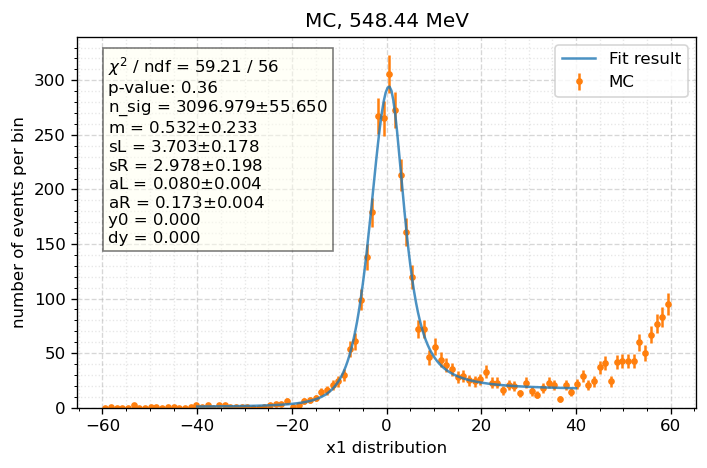

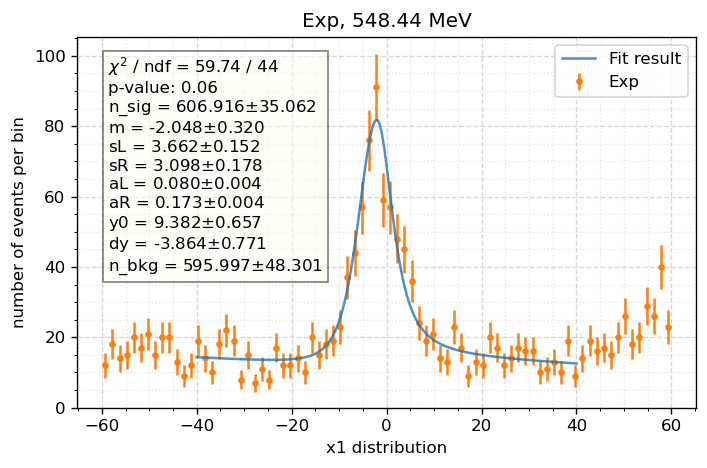

In [124]:
f_mc.plot(hist_range, 100, f'MC, {e0:.2f} MeV', 'MC', 'x1 distribution', 
       'number of events per bin', fill_errors=False)
f_exp.plot(hist_range, 80, f'Exp, {e0:.2f} MeV', 'Exp', 'x1 distribution', 
       'number of events per bin', fill_errors=False)